![](../assets/images/ga_logo.png)

-----

# Project 4: GameStop Historical Stock Prices

In [218]:
# Requirement to install for new models:

#1!pip install pystan --user

#2 https://visualstudio.microsoft.com/visual-cpp-build-tools/ 
#2 install only c++ in the wizard above

#3 conda install libpython m2w64-toolchain -c msys2
#3 With admin prev

#4 !pip install fbprophet --user

# Problem

- GameStop's stocks have spiked in recent days since the Reddit group blew up the stock price. Now GameStop is up more than 1,700% since the start of January. So we will try to predict the stock market for it after everything happen in the market sales for the past months. And identify the `adjclose_price` for it.

# Goal

- Evaluate models.
- Forcast the adjclose_price.
- Compare mdoels.

# Team:

| Team               |1                   |2                     |3                |
|:-------------------|:------------------:|:--------------------:|:---------------:|
|NMR                 |*Mohammed Al-Hamad* |*Ragad Alabdullateef* |*Najwa Al-Saadi* |

Dataset on Kaggle [GameStop Historical Stock Prices](https://www.kaggle.com/hananxx/gamestop-historical-stock-prices)

---

In [219]:
#Data
import pandas as pd 
import numpy as np 

#ploting
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

#Time libs
from datetime import datetime
from pmdarima import auto_arima
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from fbprophet.plot import add_changepoints_to_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor


#Displaying options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


#Set styles
%matplotlib inline
set_matplotlib_formats('retina')
plt.style.use('default')

#Ignore unwanted warnings
import warnings
warnings.filterwarnings('ignore')

In [220]:
note = pd.DataFrame(columns=['Model','score'])

def add_note(Model, score):
    global note
    note.loc[Model] = [score]

In [221]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    
    result = adfuller(series.dropna(), autolag='AIC') # .dropna() handles differenced data
            
    if result[1] <= 0.05:
        print("Stationary")
        
    else:
        print("Not-stationary")

In [222]:
def autocorr_plots(y, lags=None):
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
    plot_acf(y, lags=lags, ax=ax[0])
    plot_pacf(y, lags=lags, ax=ax[1])
    return fig, ax

<br><br>

---

<br><br>

## Meta data

<pre>
Date           - The date of trading
Open_price     - The opening price of the stock
High_price     - The highest price of that day
Low_price      - The lowest price of that day 
Close_price    - The closed price of that day
Volume_price   - The amount of stocks traded during that day
Adjclose_price - The stock's closing price has been amended to include any distributions/corporate actions that occur before the next days open.    
</pre>
<br>

<br><br>

---

<br><br>

# Read the data

In [223]:
# Read data
df = pd.read_csv('../data/GME_stock.csv')

<br><br>

---

<br><br>

# 1) Exploratory data analysis and Feature engineering

In [224]:
#Print head
df.head()

,date,open_price,high_price,low_price,close_price,volume_price,adjclose_price
0,2021-01-28,265,483,112,193,58815800,193
1,2021-01-27,354,380,249,347,93396700,347
2,2021-01-26,88,150,80,147,178588000,147
3,2021-01-25,96,159,61,76,177874000,76
4,2021-01-22,42,76,42,65,196784300,65


- Columns names seems good, except `volume_price` it's the total volume of different Stocks.
- No strings between numbers for now.
- Let's check the data types.

In [225]:
df.rename(columns=({'volume_price':'total_volume'}), inplace=True)

In [226]:
#Print shape
df.shape

(4773, 7)

- We have `4773` observations, and `7` columns

## Data types

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773 entries, 0 to 4772
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            4773 non-null   object
 1   open_price      4773 non-null   int64 
 2   high_price      4773 non-null   int64 
 3   low_price       4773 non-null   int64 
 4   close_price     4773 non-null   int64 
 5   total_volume    4773 non-null   int64 
 6   adjclose_price  4773 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 261.1+ KB


**`date` column is `object` type, It must be `datetime`.**

In [228]:
#Convert to datetime
df['date'] = pd.to_datetime(df['date'])

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773 entries, 0 to 4772
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            4773 non-null   datetime64[ns]
 1   open_price      4773 non-null   int64         
 2   high_price      4773 non-null   int64         
 3   low_price       4773 non-null   int64         
 4   close_price     4773 non-null   int64         
 5   total_volume    4773 non-null   int64         
 6   adjclose_price  4773 non-null   int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 261.1 KB


- Everything seems good here.

---

## Sort rows by `Date` in ascending order

In [230]:
df.sort_values('date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,date,open_price,high_price,low_price,close_price,total_volume,adjclose_price
0,2002-02-13,9,10,9,10,19054000,6
1,2002-02-14,10,10,9,10,2755400,6
2,2002-02-15,10,10,9,9,2097400,6
3,2002-02-19,9,9,9,9,1852600,6
4,2002-02-20,9,9,9,9,1723200,6


<br><br>

---

<br><br>

## Describe Data

In [231]:
df.describe(datetime_is_numeric = True).T

,count,mean,min,25%,50%,75%,max,std
date,4773,2011-08-06 00:45:33.375250432,2002-02-13 00:00:00,2006-11-07 00:00:00,2011-08-04 00:00:00,2016-05-03 00:00:00,2021-01-28 00:00:00,NaN
open_price,4773,22.7123,2,11,21,29,354,14.7051
high_price,4773,23.1976,2,11,22,30,483,16.2202
low_price,4773,22.2303,2,11,21,28,249,13.6393
close_price,4773,22.7012,2,11,21,29,347,14.5174
total_volume,4773,3.39825e+06,65000,1.5289e+06,2.4918e+06,3.7916e+06,1.96784e+08,6.54704e+06
adjclose_price,4773,16.3868,2,9,15,22,347,11.0101


- We have 4773 dates.
- Date starts at `2002-02-13`.
- Date ends at `2021-01-28`.
- The mid Date is `2011-08-04`.

---

# Null values:

In [232]:
df.isnull().sum()

date              0
open_price        0
high_price        0
low_price         0
close_price       0
total_volume      0
adjclose_price    0
dtype: int64

- We don't have Null values, **which is good so far.**

<br><br>

---

<br><br>

In [233]:
#.set_index()  Do not forget to use inplace
df.set_index('date',inplace=True)
df.index.name = None

In [234]:
df.head()

,open_price,high_price,low_price,close_price,total_volume,adjclose_price
2002-02-13,9,10,9,10,19054000,6
2002-02-14,10,10,9,10,2755400,6
2002-02-15,10,10,9,9,2097400,6
2002-02-19,9,9,9,9,1852600,6
2002-02-20,9,9,9,9,1723200,6


<br><br>

---

<br><br>

In [235]:
df.index.to_list()

[Timestamp('2002-02-13 00:00:00'),
 Timestamp('2002-02-14 00:00:00'),
 Timestamp('2002-02-15 00:00:00'),
 Timestamp('2002-02-19 00:00:00'),
 Timestamp('2002-02-20 00:00:00'),
 Timestamp('2002-02-21 00:00:00'),
 Timestamp('2002-02-22 00:00:00'),
 Timestamp('2002-02-25 00:00:00'),
 Timestamp('2002-02-26 00:00:00'),
 Timestamp('2002-02-27 00:00:00'),
 Timestamp('2002-02-28 00:00:00'),
 Timestamp('2002-03-01 00:00:00'),
 Timestamp('2002-03-04 00:00:00'),
 Timestamp('2002-03-05 00:00:00'),
 Timestamp('2002-03-06 00:00:00'),
 Timestamp('2002-03-07 00:00:00'),
 Timestamp('2002-03-08 00:00:00'),
 Timestamp('2002-03-11 00:00:00'),
 Timestamp('2002-03-12 00:00:00'),
 Timestamp('2002-03-13 00:00:00'),
 Timestamp('2002-03-14 00:00:00'),
 Timestamp('2002-03-15 00:00:00'),
 Timestamp('2002-03-18 00:00:00'),
 Timestamp('2002-03-19 00:00:00'),
 Timestamp('2002-03-20 00:00:00'),
 Timestamp('2002-03-21 00:00:00'),
 Timestamp('2002-03-22 00:00:00'),
 Timestamp('2002-03-25 00:00:00'),
 Timestamp('2002-03-

- We will take the dates as monthly, due to missing for days in each month in each year

In [236]:
#Resample date as Month's first
rdf = df.resample('MS').mean()
rdf.head(15)

,open_price,high_price,low_price,close_price,total_volume,adjclose_price
2002-02-01,9.181818,9.272727,9.000000,9.181818,3.033873e+06,6.000000
2002-03-01,9.450000,9.550000,9.250000,9.450000,8.496700e+05,6.250000
2002-04-01,9.090909,9.272727,8.954545,9.090909,4.376636e+05,6.000000
2002-05-01,10.409091,10.772727,10.181818,10.454545,6.533182e+05,6.909091
2002-06-01,10.600000,10.700000,10.300000,10.550000,3.241100e+05,6.800000
2002-07-01,8.318182,8.681818,7.909091,8.318182,3.998091e+05,5.454545
2002-08-01,8.636364,8.818182,8.500000,8.636364,5.121545e+05,5.772727
2002-09-01,9.650000,9.850000,9.200000,9.650000,3.302100e+05,6.100000
2002-10-01,9.173913,9.347826,8.913043,9.130435,5.710957e+05,6.000000
2002-11-01,8.850000,9.000000,8.650000,8.950000,6.216100e+05,5.850000


In [237]:
rdf.shape

(228, 6)

<br><br>

---

<br><br>

## Plot the data

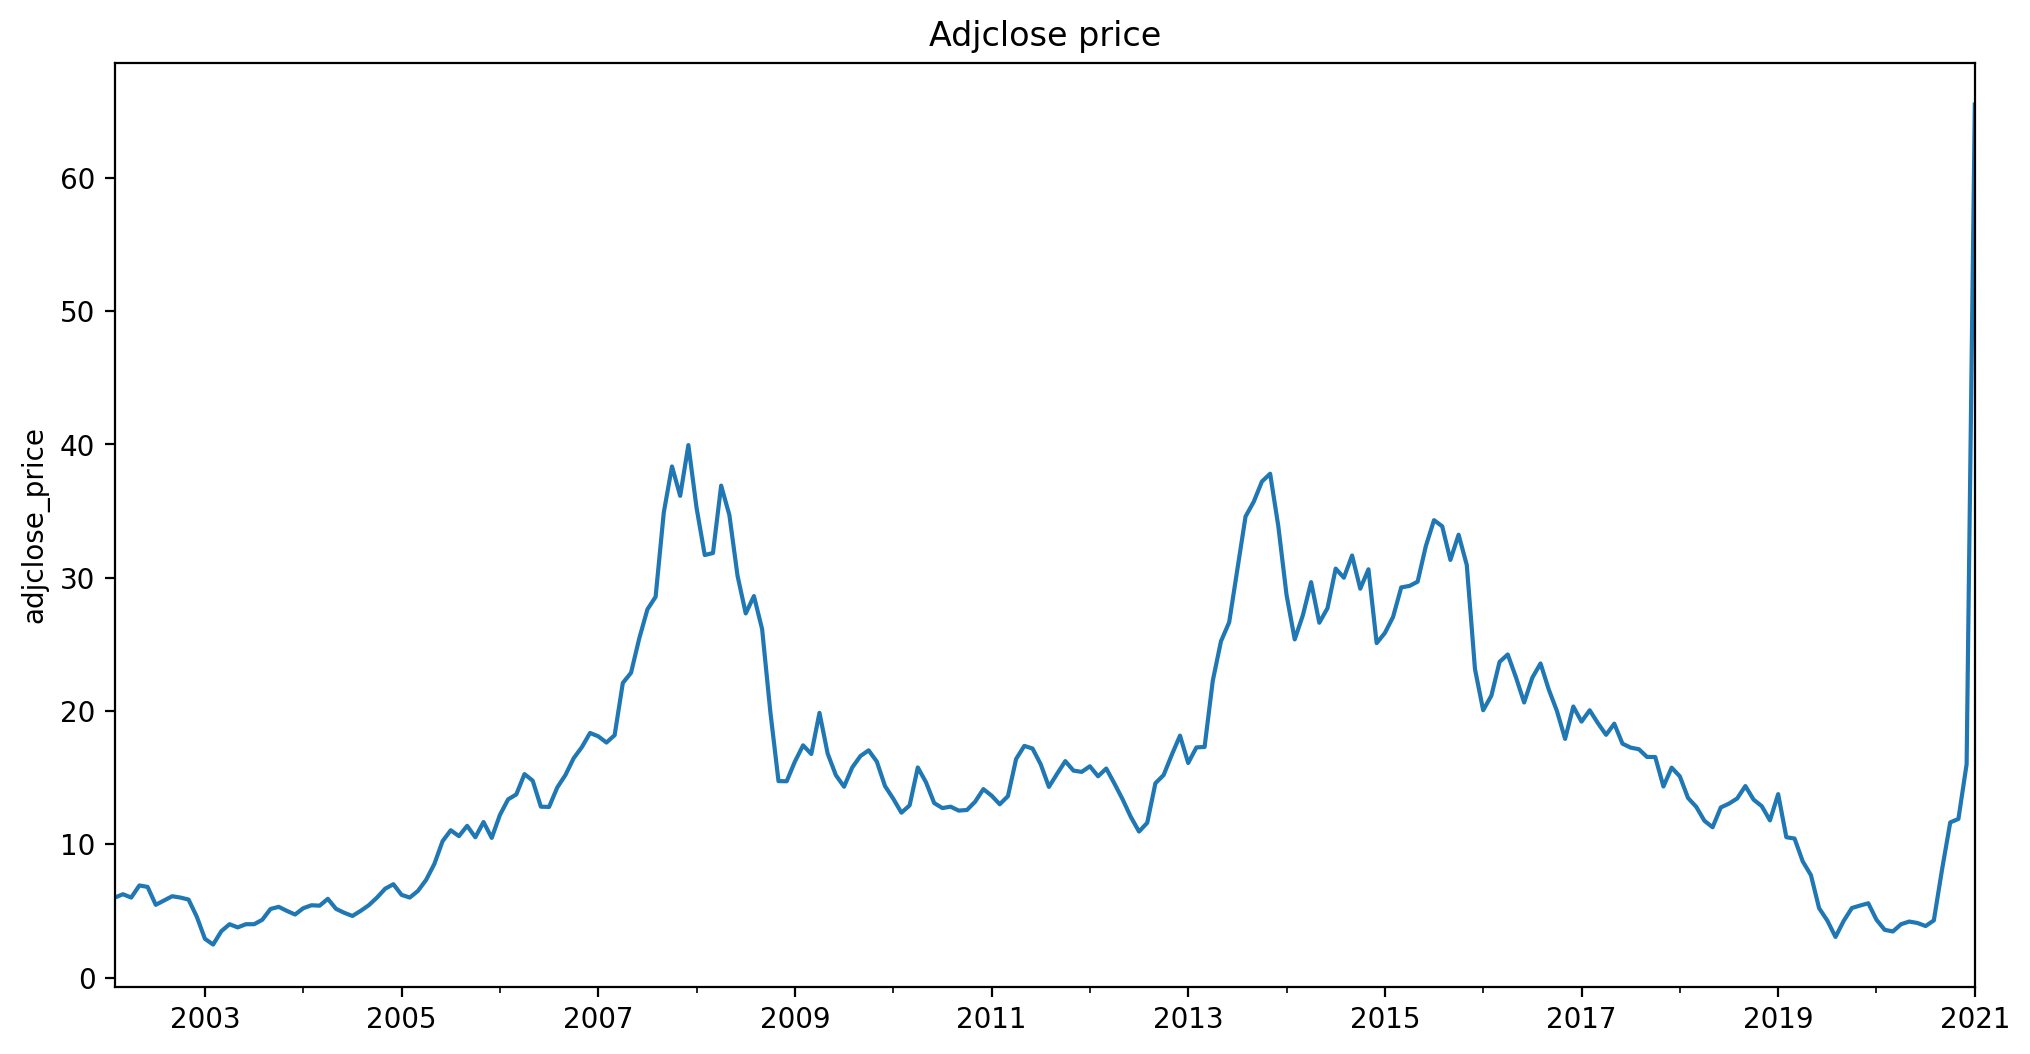

In [238]:
title = 'Adjclose price'
ylabel= 'adjclose_price'
xlabel='' 

ax = rdf['adjclose_price'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

- From `2003` to `2007` there was an increase in the prices.
- A sharp decrease has occurred between `2008` and `2009`.
- After `2013` it starts to heal again.
- A sharp increase occurred after `2020`.

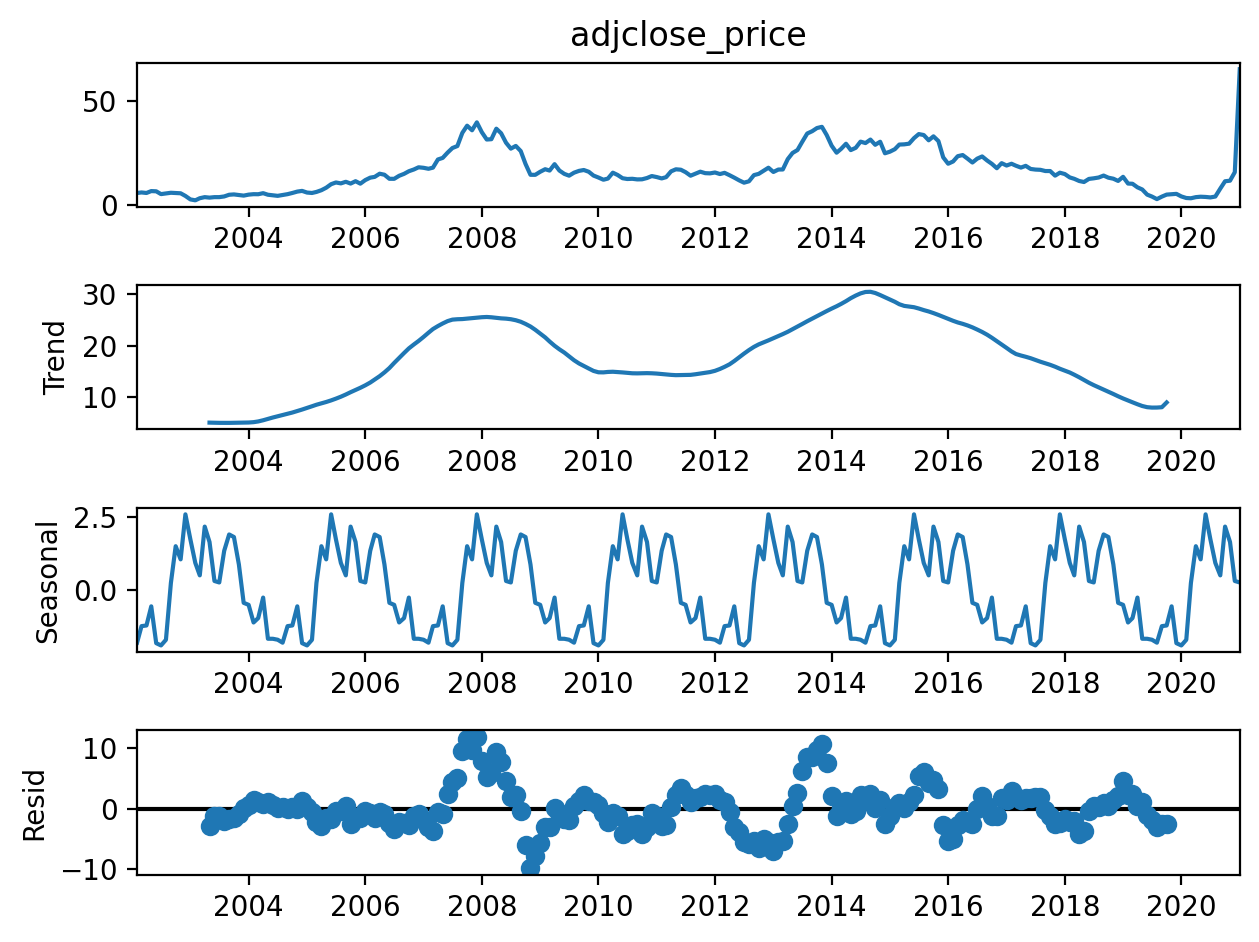

In [239]:
result = seasonal_decompose(rdf['adjclose_price'], freq=30)
result.plot();

- Our data is seasonal

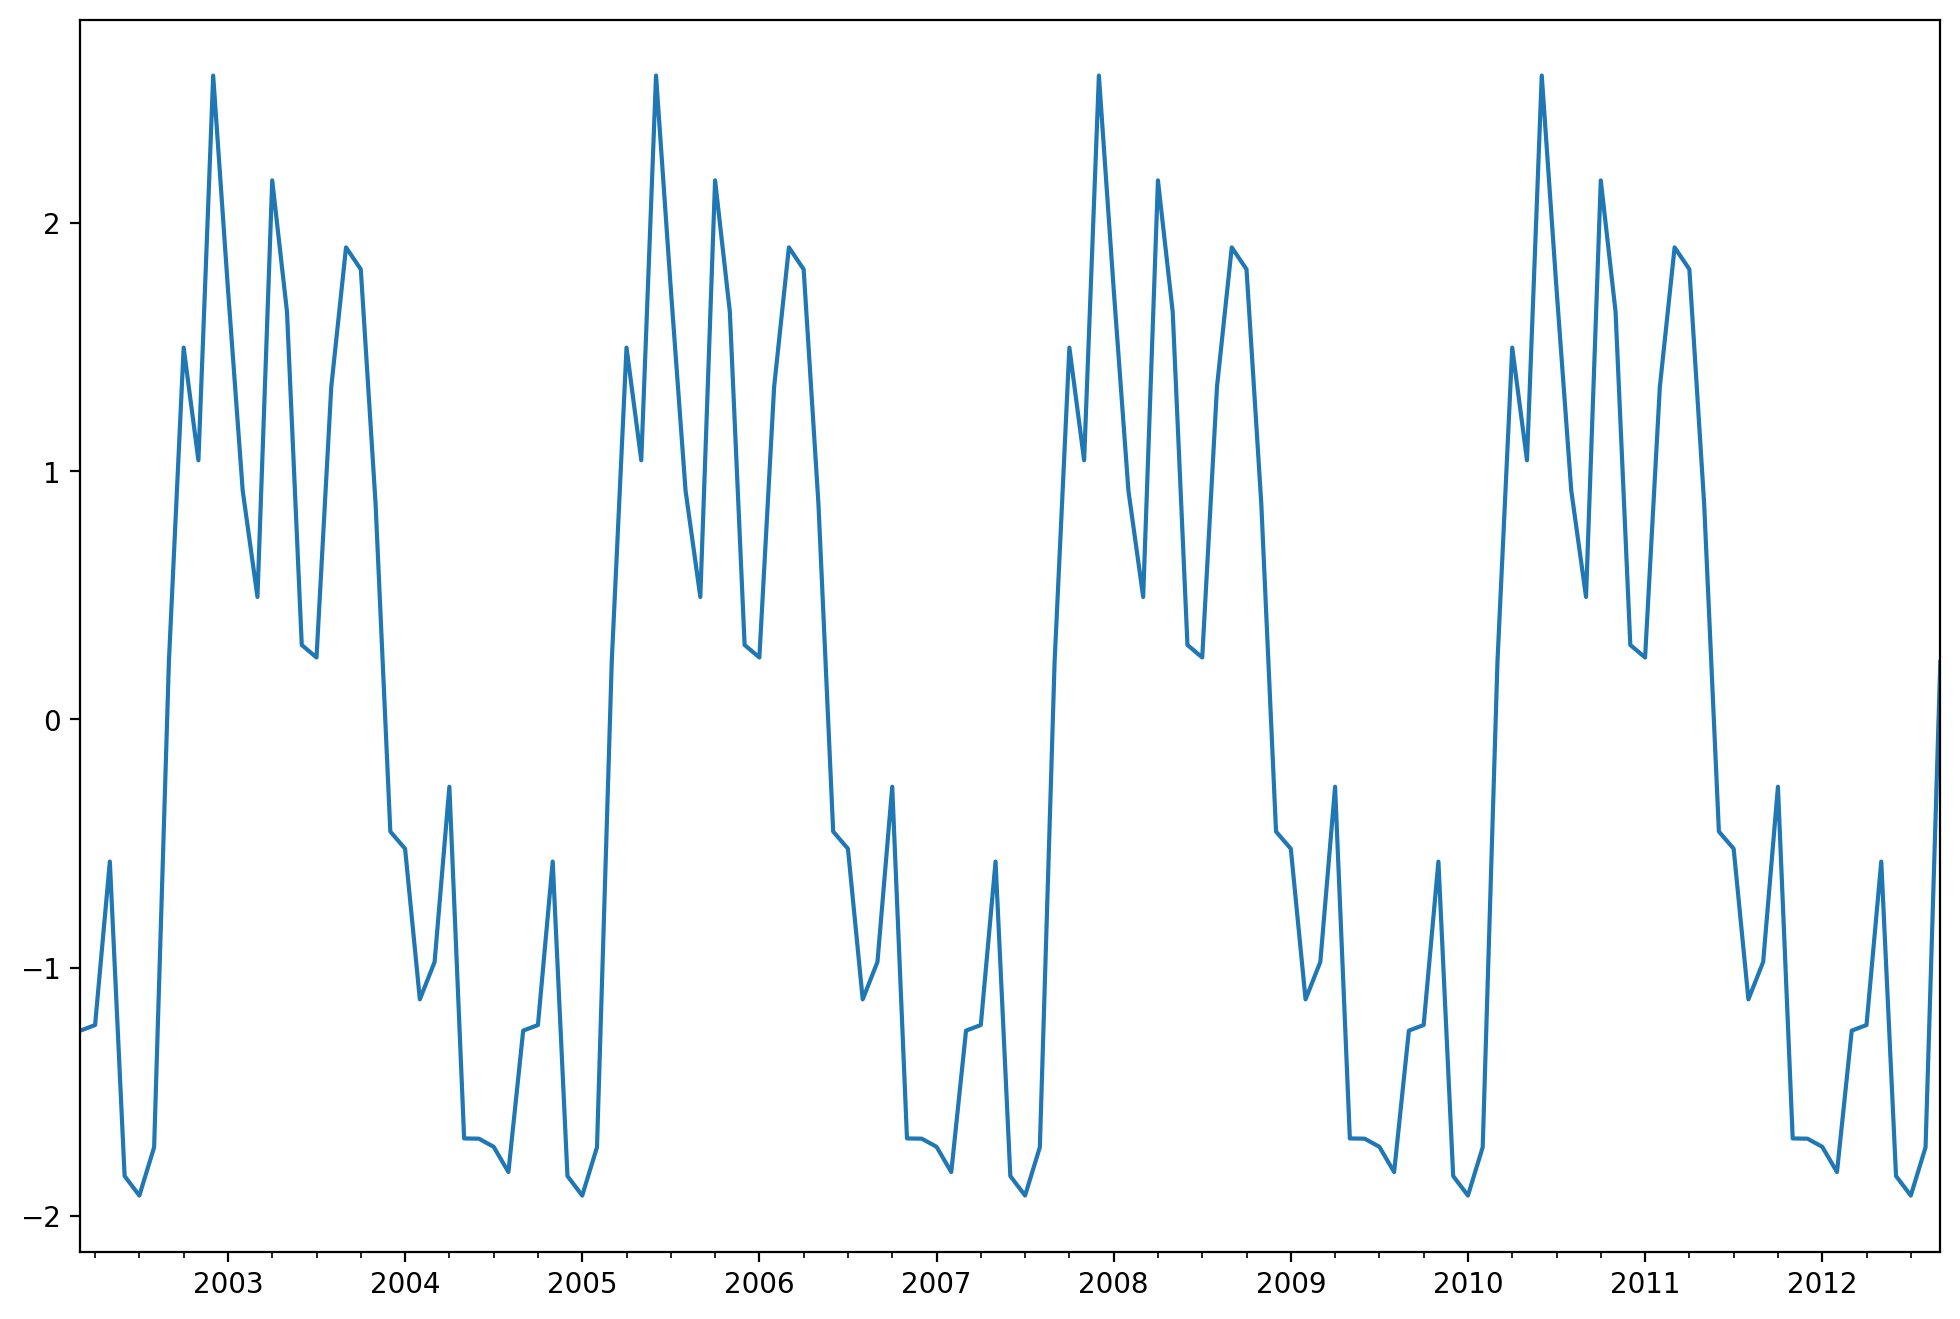

In [240]:
# plot the seasonlity in a higher scale
ax=result.seasonal[1:128].plot(figsize=(12,8))

- Our season period occurring every 2.5 years.
- 2.5 year = 30 months.

# Check the stationarity

In [241]:
adf_test(rdf.adjclose_price)

Augmented Dickey-Fuller Test: 
Not-stationary


- Our data is not stationary, but we will use Auto-ARIMA to determine (p,d,q).

<br><br>

---

<br><br>

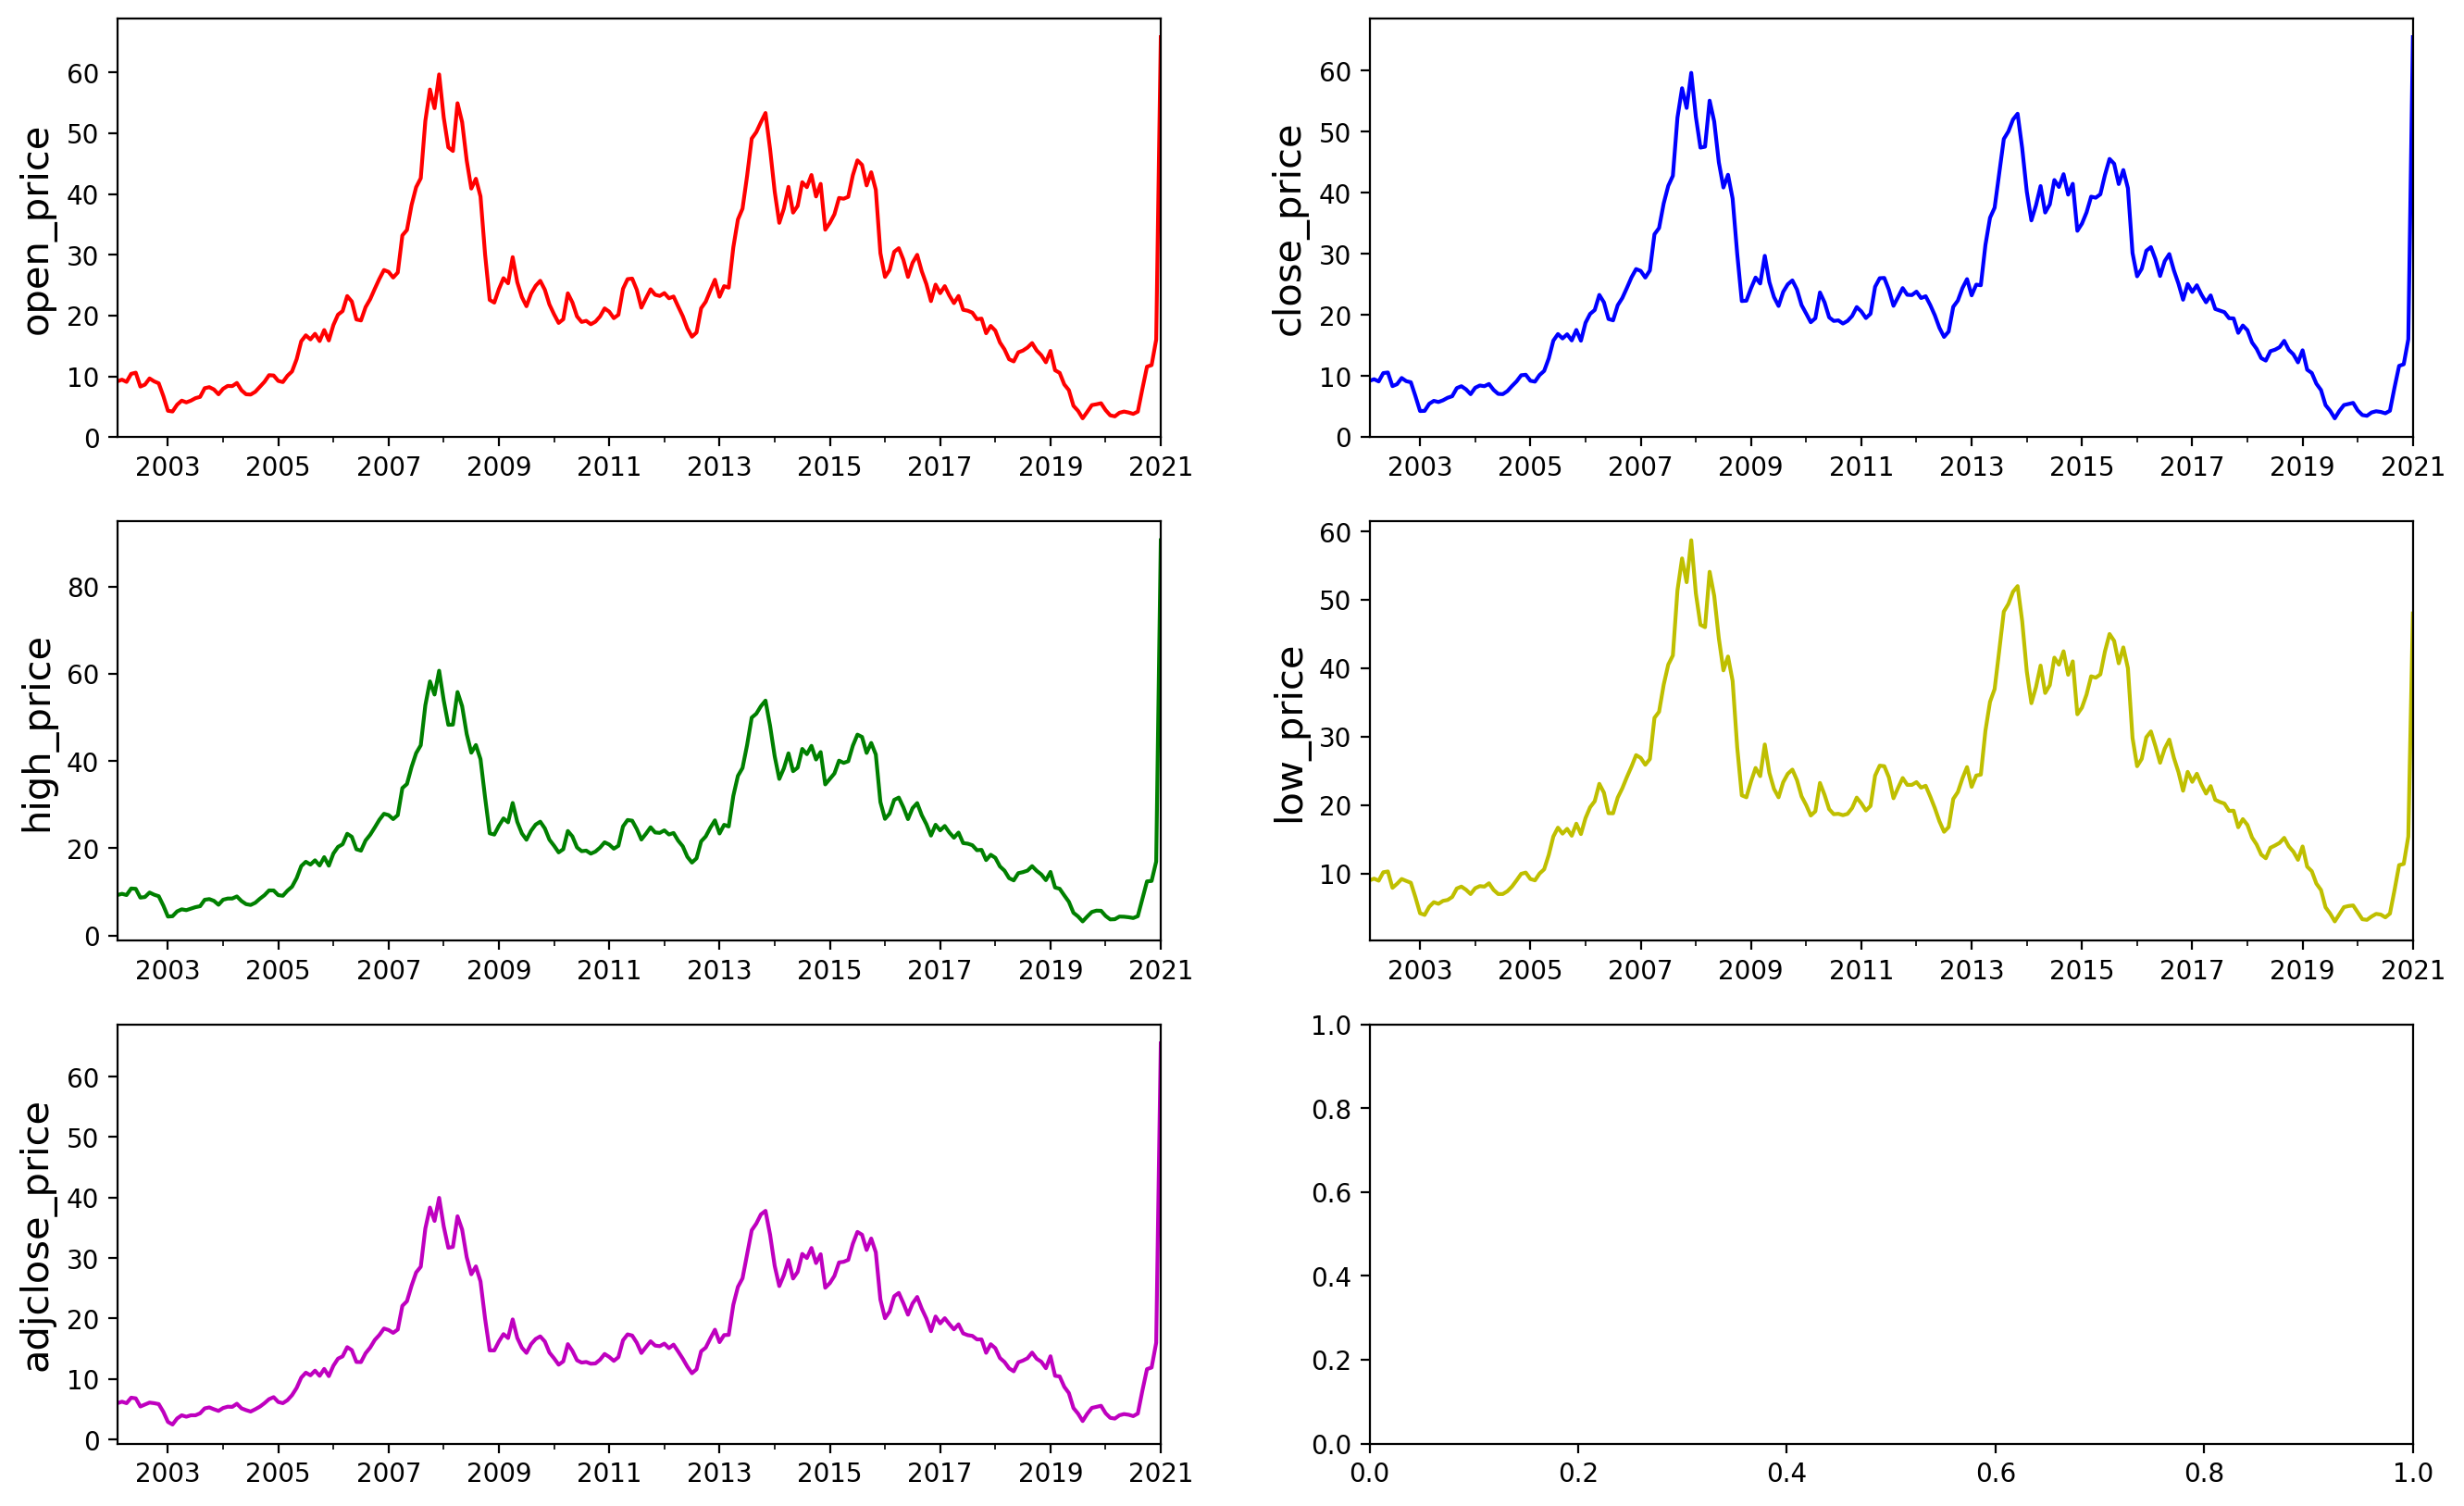

In [242]:
fig, axes = plt.subplots(3,2, figsize=(12,12))

rdf.open_price.plot(figsize=(16,10),c='r',ax=axes[0][0])

rdf.close_price.plot(figsize=(16,10),c='b',ax=axes[0][1])

rdf.high_price.plot(figsize=(16,10),c='g',ax=axes[1][0])

rdf.low_price.plot(figsize=(16,10),c='y',ax=axes[1][1])

rdf.adjclose_price.plot(figsize=(16,10),c='m',ax=axes[2][0])


axes[0][0].set_ylabel('open_price', fontsize = 15) 

axes[0][1].set_ylabel('close_price', fontsize = 15) 

axes[1][0].set_ylabel('high_price', fontsize = 15) 

axes[1][1].set_ylabel('low_price', fontsize = 15) 

axes[2][0].set_ylabel('adjclose_price', fontsize = 15);

<br><br>

---

<br><br>

# Our finding

- The data has an increasing sharp occurred after 2020, which will affect the modelling processes in general.
- We will train the 3 selected models with and without the sharp increase after 2020.
- We will compare all models by evaluate and forcasting.

<br><br>

---

<br><br>

<center> 
    <font color='tan' size='50px'>  Modeling

In [243]:
#Create a scoring data frame and functiont to add score
rmse_df = pd.DataFrame(columns=['Model','Test'])

def add_score(model_name, score):    
    global rmse_df
    #Appened model with the score
    rmse_df = rmse_df.append({'Model':model_name,
                              'Test':score},ignore_index=True).sort_values('Test').reset_index(drop=True)
    return rmse_df.sort_values('Test')


# Selecting (p,d,q), and spliting

- We will use Auto-ARIMA to determine (p,d,q)

<center> <font size='6' color='red'> Full data modelling

## Auto-ARIMA

In [244]:
auto_fit = auto_arima(rdf['adjclose_price'],
           seasonal=True,
           m=30)      

auto_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  228
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -618.439
Date:                Wed, 10 Feb 2021   AIC                           1240.879
Time:                        15:20:17   BIC                           1247.729
Sample:                             0   HQIC                          1243.643
                                - 228                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4314      0.137      3.152      0.002       0.163       0.700
sigma2        13.5993      0.402     33.807      0.000      12.811      14.388
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):            135924.60
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):              11.24   Skew:                             9.31
Prob(H) (two-sided):                  0.00   Kurtosis:                       121.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<br><br>

---

<br><br>

## Split the data into train and test

In [245]:
#Split the data into train and test
df_train = rdf.adjclose_price.iloc[:-30]
df_test = rdf.adjclose_price.iloc[-30:]  

In [246]:
df_train.shape , df_test.shape

((198,), (30,))

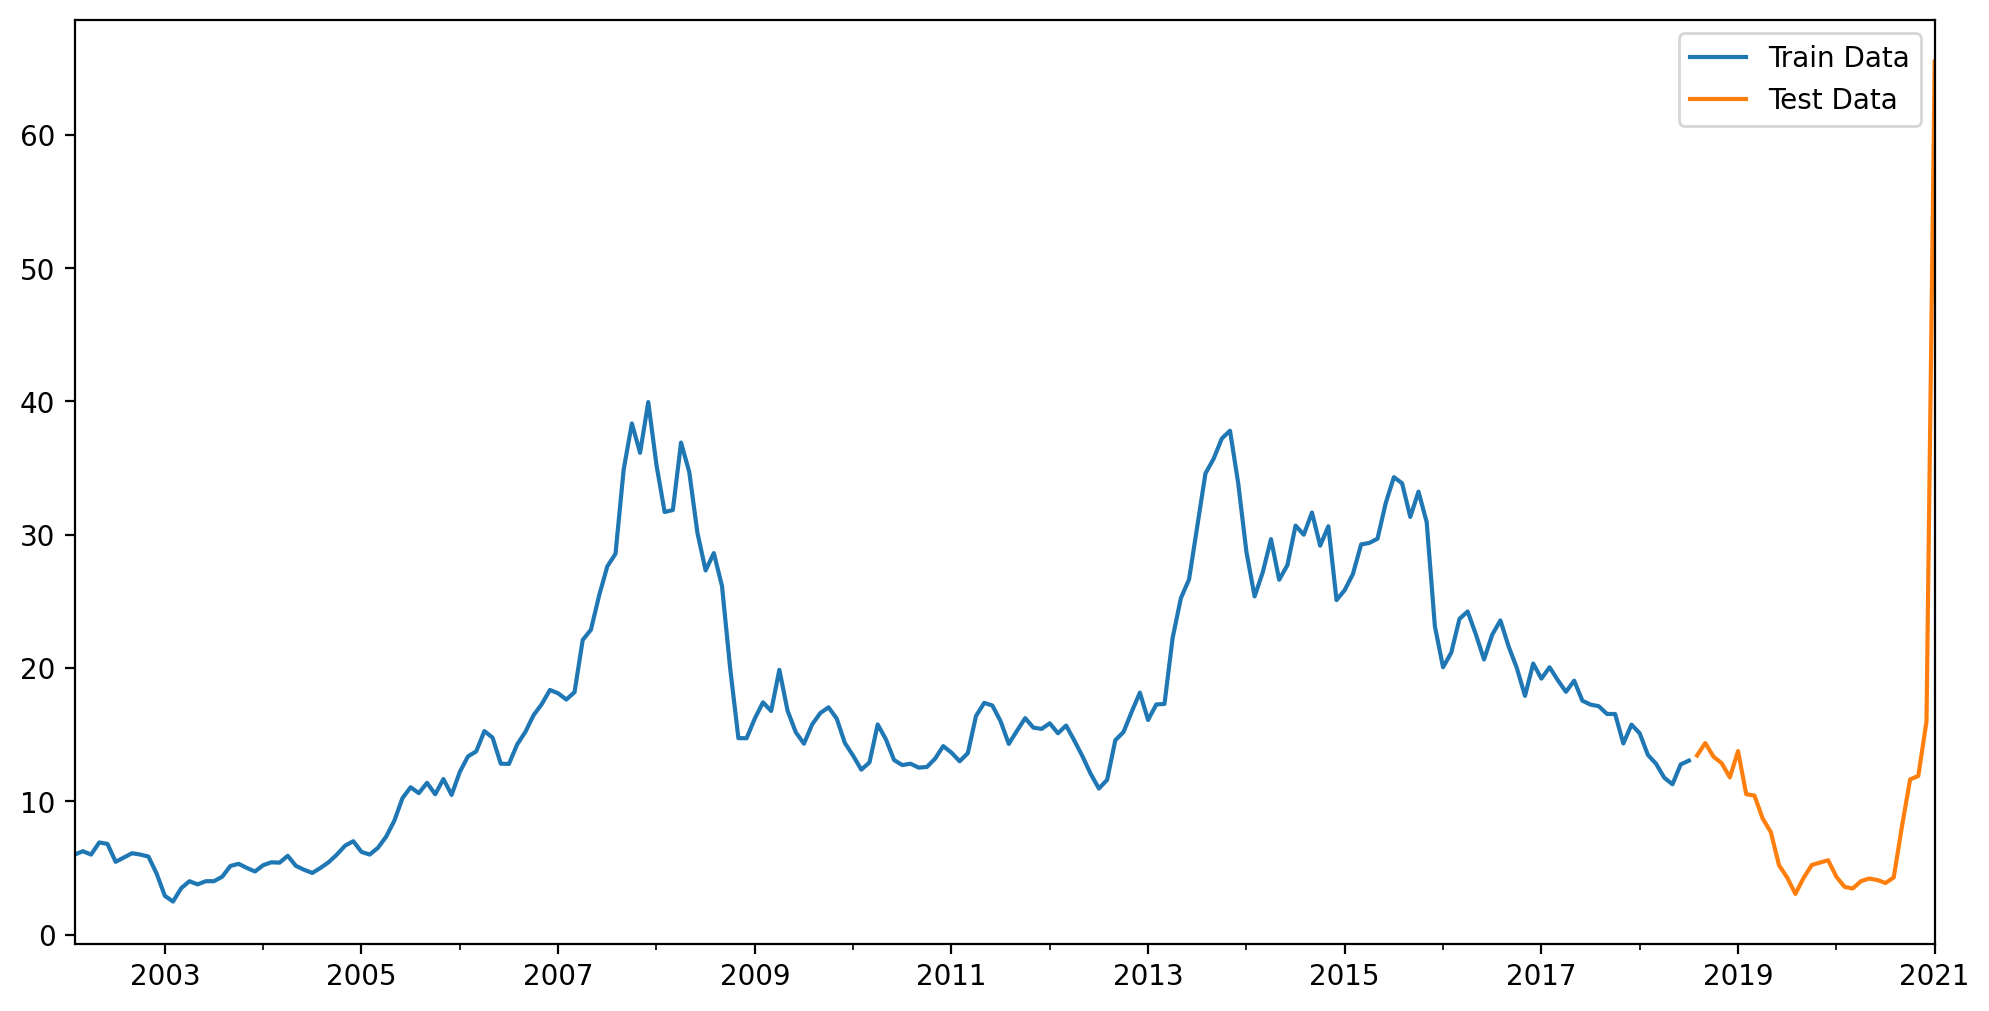

In [247]:
# Plot the train and test sets on the axis ax
fig, ax = plt.subplots(figsize=(12,6))

df_train.plot(ax=ax)
df_test.plot(ax=ax)

ax.legend(labels=['Train Data','Test Data']);

<br><br>

---

<br><br>

<font size='5' color='blue'> Model 1: SARIMAX

In [248]:
model1 = SARIMAX(df_train,
                 order=(0,1,1))

results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         adjclose_price   No. Observations:                  198
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -405.280
Date:                Wed, 10 Feb 2021   AIC                            814.560
Time:                        15:20:17   BIC                            821.126
Sample:                    02-01-2002   HQIC                           817.218
                         - 07-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2626      0.048      5.526      0.000       0.169       0.356
sigma2         3.5833      0.258     13.870      0.000       3.077       4.090
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                36.39
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.40   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 1.1) Predict SARIMAX model

In [249]:
# Obtain predicted values
start = len(df_train)
end = len(df_train) + len(df_test)-1


In [250]:
predictions = results1.predict(start=start,
                                end=end,
                                dynamic=False,
                                typ='levels').rename('SARIMA(0,1,1)')

In [251]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted = {predictions[i]:4.4}, expected = {df_test[i]}")

predicted = 13.02, expected = 13.434782608695652
predicted = 13.02, expected = 14.368421052631579
predicted = 13.02, expected = 13.347826086956522
predicted = 13.02, expected = 12.857142857142858
predicted = 13.02, expected = 11.789473684210526
predicted = 13.02, expected = 13.761904761904763
predicted = 13.02, expected = 10.526315789473685
predicted = 13.02, expected = 10.428571428571429
predicted = 13.02, expected = 8.714285714285714
predicted = 13.02, expected = 7.681818181818182
predicted = 13.02, expected = 5.2
predicted = 13.02, expected = 4.2727272727272725
predicted = 13.02, expected = 3.0454545454545454
predicted = 13.02, expected = 4.25
predicted = 13.02, expected = 5.217391304347826
predicted = 13.02, expected = 5.4
predicted = 13.02, expected = 5.571428571428571
predicted = 13.02, expected = 4.333333333333333
predicted = 13.02, expected = 3.5789473684210527
predicted = 13.02, expected = 3.4545454545454546
predicted = 13.02, expected = 4.0
predicted = 13.02, expected = 4.2
p

## 1.2) Plot Prediction Vs True

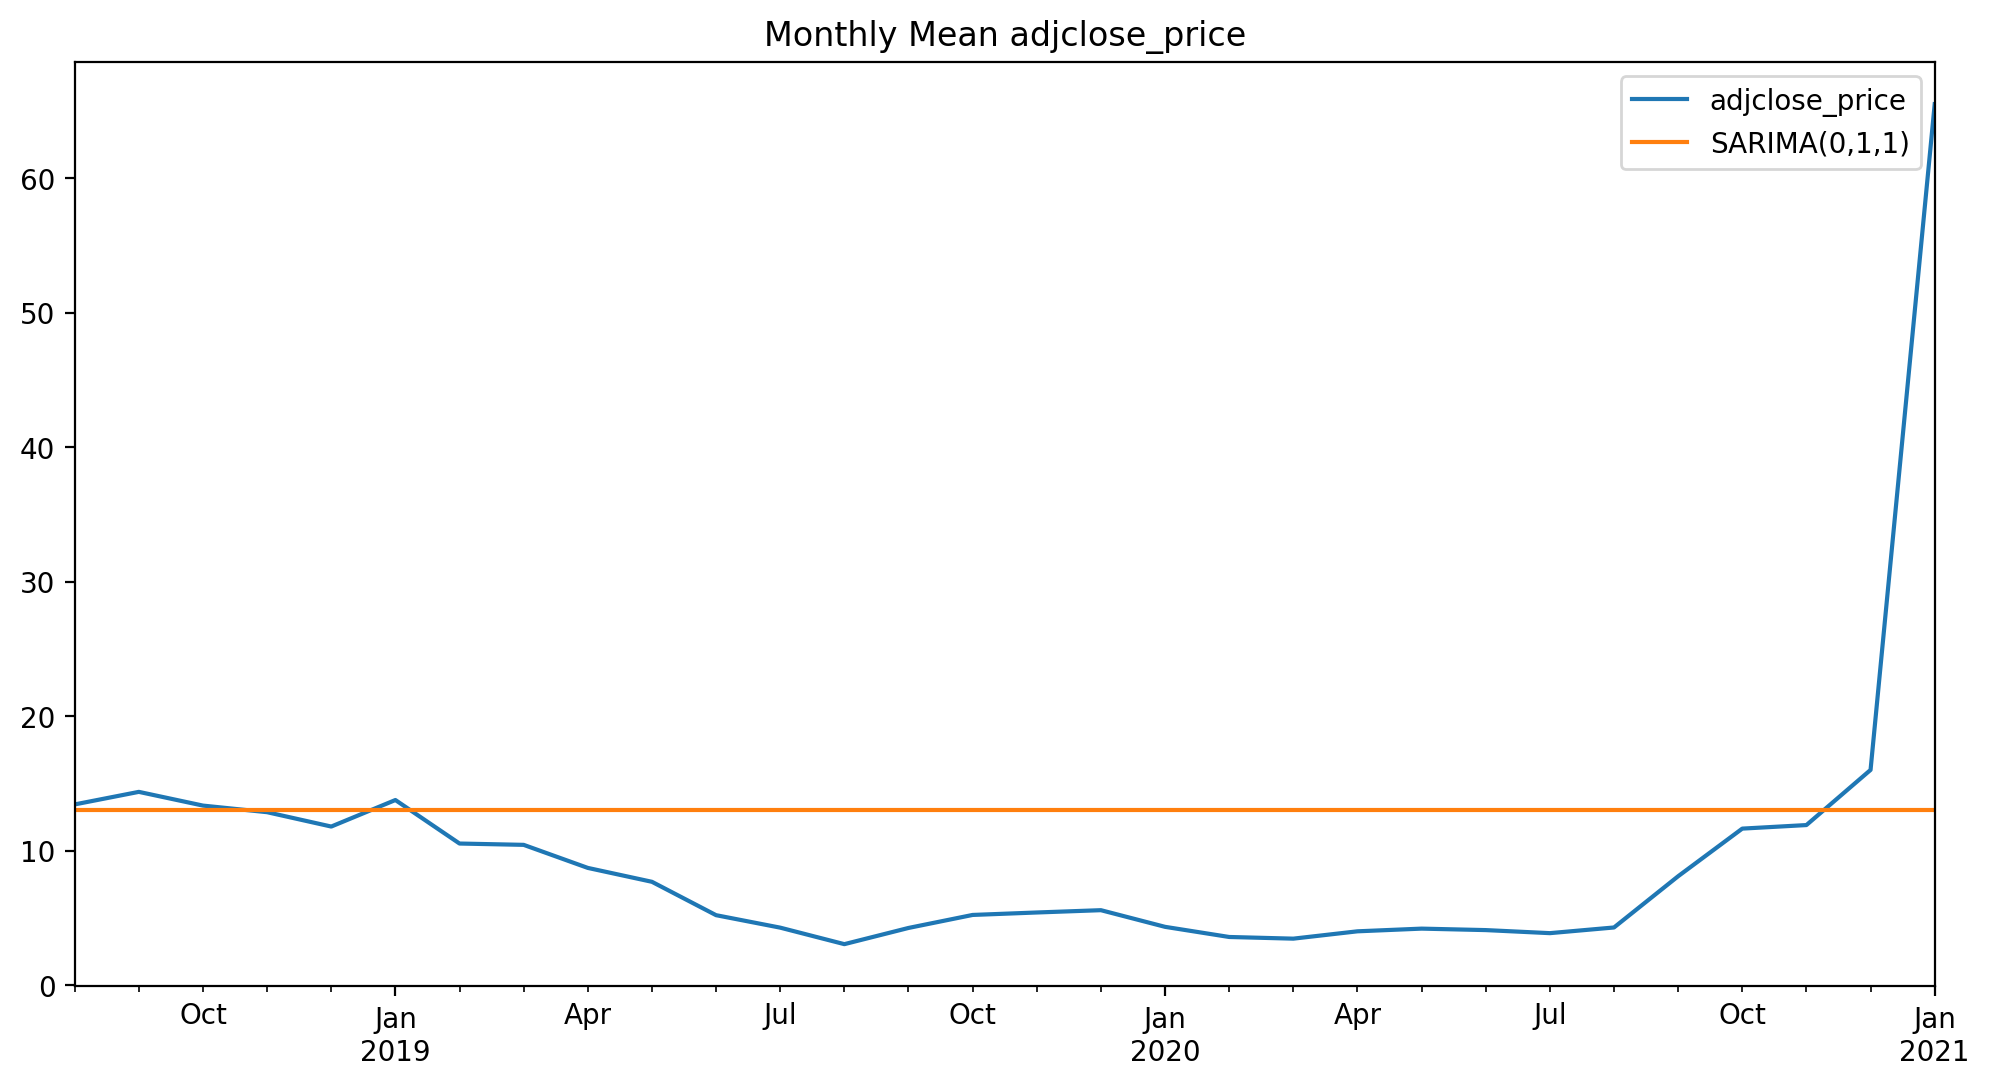

In [252]:
# Plot predictions against known values
title = 'Monthly Mean adjclose_price'

ax = df_test.plot(legend=True, figsize=(12,6), title=title)

predictions.plot(legend=True)

ax.autoscale(axis='x', tight=True)

## 1.3) Evaluate the Model

In [253]:
error1 = rmse(df_test, predictions)
print(f'SARIMAX (0, 1, 1) RMSE Error: {error1:4.8}')

SARIMAX (0, 1, 1) RMSE Error: 11.543219


In [254]:
rdf['adjclose_price'].mean()

16.387499519897453

- The RMSE for SARIMAX equal `+/- 11.543219`, and the mean of adjclose_price is equal `16.3874`.
- The model couldn't predict on the data this might be caused by the sharp after 2021.
- The model used the mean as prediction for the test data.
- We will focast the next 2.5 year and see the results.

In [255]:
add_score('F-SARIMAX', rmse(df_test, predictions))


,Model,Test
0,F-SARIMAX,11.543219


##  1.4) Retrain the model and forecast the future

In [256]:
model = SARIMAX(rdf['adjclose_price'],
                order=(0,1,1))

results = model.fit()

fcast = results.predict(len(rdf),
                        len(rdf) + 30,
                        typ='levels').rename('SARIMA(0,1,1) Forecast')

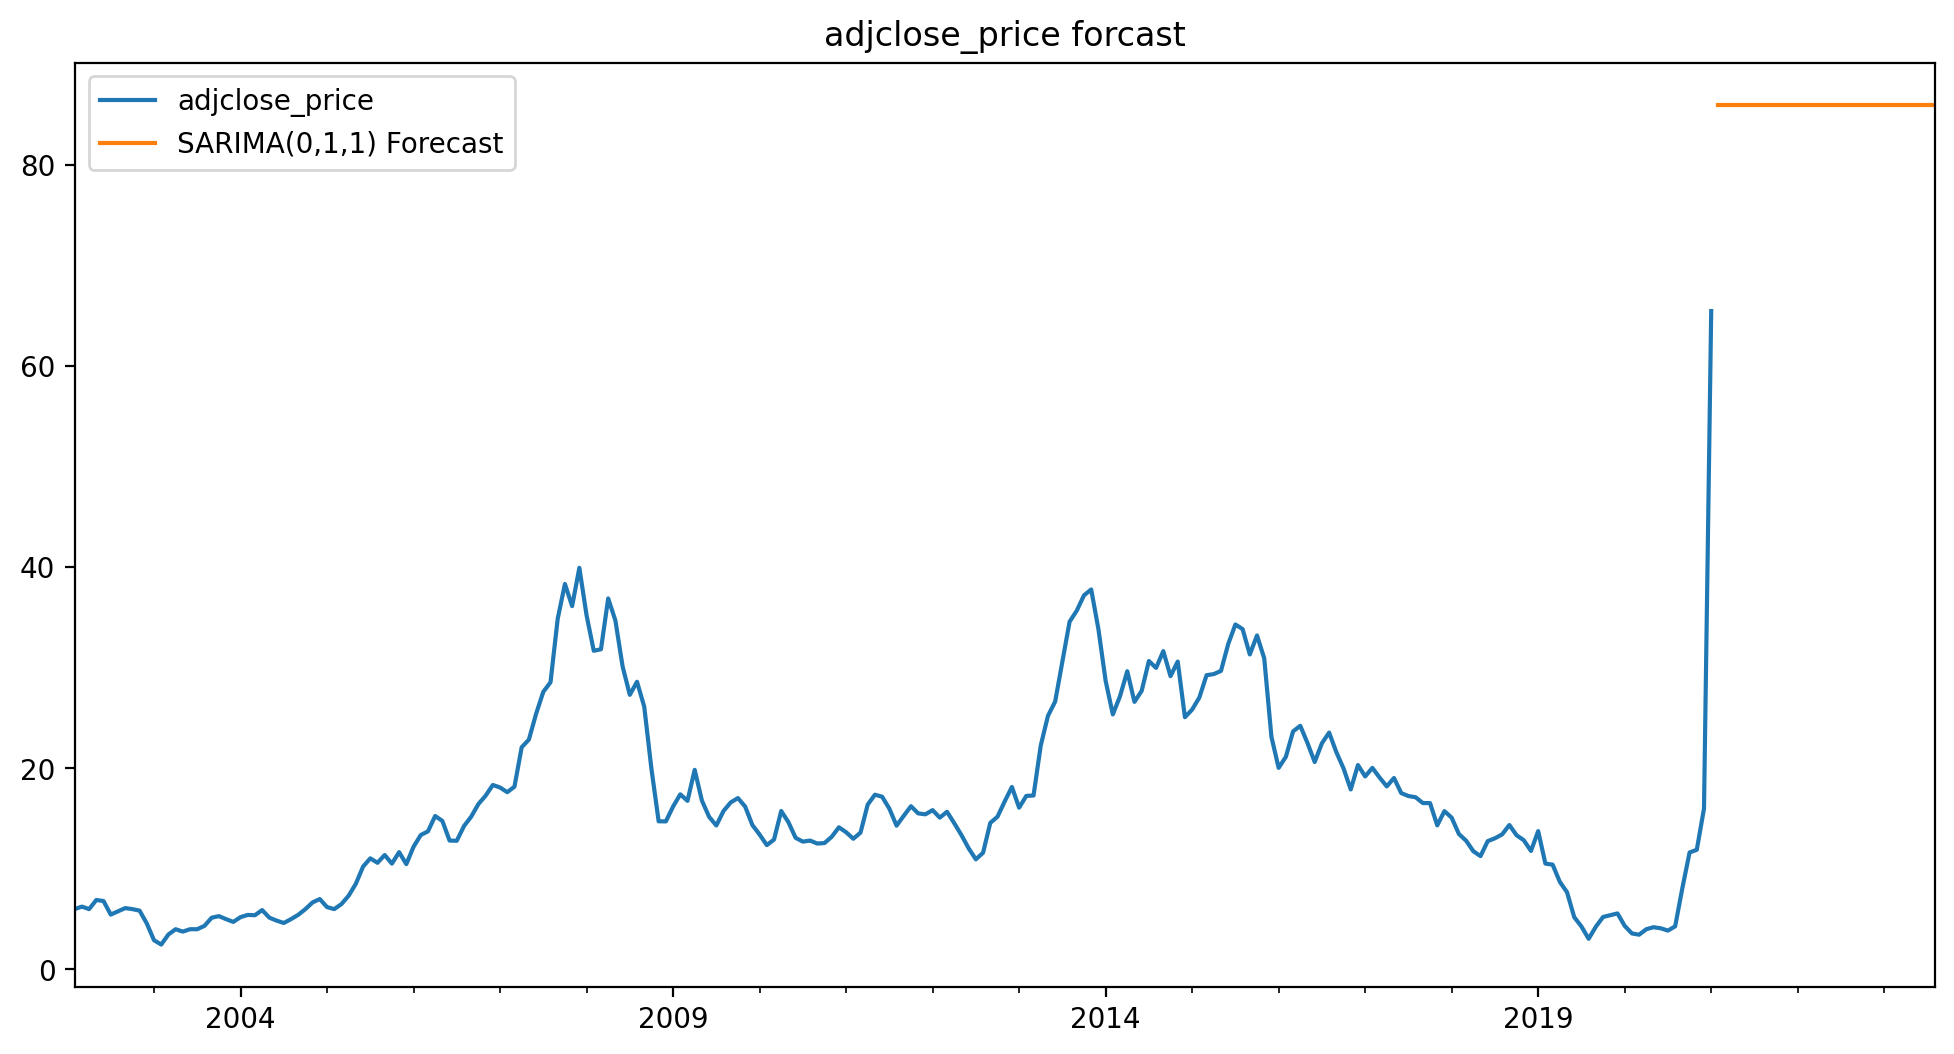

In [257]:
# Plot predictions against known values
title = 'adjclose_price forcast'

ax = rdf['adjclose_price'].plot(legend=True,
                                figsize=(12,6),
                                title=title)
fcast.plot(legend=True)

ax.autoscale(axis='x',
             tight=True)

- As we said before the model learned to predeict based on the mean, and we can see the forcasting that made was a stright line.

<br><br>

---

<br><br>

<font size='5' color='blue'> Model 2: Facebook Prophet

## Prepare data

In [258]:
#Prepare the data for Facebook Prophet model

#Get the predictor and reset index to get the date
df_p = rdf[['adjclose_price']].reset_index()

#Rename the index to ds and predictor to y. 
#It's a must for this model
df_p.rename(columns={'index':'ds',
                   'adjclose_price':'y'},
          inplace=True)

#Print the head to check
df_p.head()

,ds,y
0,2002-02-01,6.000000
1,2002-03-01,6.250000
2,2002-04-01,6.000000
3,2002-05-01,6.909091
4,2002-06-01,6.800000


## Split data to train and test

In [259]:
#Split data to train and test, taking one session = 2.5 year 
df_train = df_p.iloc[:-30]
df_test = df_p.iloc[-30:] 

##  Prophet

In [260]:
#Calling Prophet model
prophet = Prophet()

#Fitting the model
prophet.fit(df_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 2.1) Predict Prophet model

In [261]:
test_prediction = prophet.predict(df_test)

In [262]:
# Compare predictions to expected values
for i in range(len(test_prediction)):
    print(f'predicted = {test_prediction.yhat.iloc[i]:4.3} | expected = {df_test.y.iloc[i]:4.3}')

predicted = 24.4 | expected = 13.4
predicted = 24.9 | expected = 14.4
predicted = 24.8 | expected = 13.3
predicted = 24.2 | expected = 12.9
predicted = 23.4 | expected = 11.8
predicted = 22.4 | expected = 13.8
predicted = 22.3 | expected = 10.5
predicted = 22.4 | expected = 10.4
predicted = 24.0 | expected = 8.71
predicted = 23.7 | expected = 7.68
predicted = 23.6 | expected =  5.2
predicted = 23.8 | expected = 4.27
predicted = 24.7 | expected = 3.05
predicted = 25.2 | expected = 4.25
predicted = 25.2 | expected = 5.22
predicted = 24.6 | expected =  5.4
predicted = 23.8 | expected = 5.57
predicted = 22.9 | expected = 4.33
predicted = 22.9 | expected = 3.58
predicted = 23.3 | expected = 3.45
predicted = 24.6 | expected =  4.0
predicted = 24.1 | expected =  4.2
predicted = 23.6 | expected = 4.09
predicted = 24.0 | expected = 3.86
predicted = 25.3 | expected = 4.29
predicted = 25.9 | expected =  8.1
predicted = 25.6 | expected = 11.6
predicted = 25.0 | expected = 11.9
predicted = 24.3 | e

## 2.2) Plot Prediction Vs True

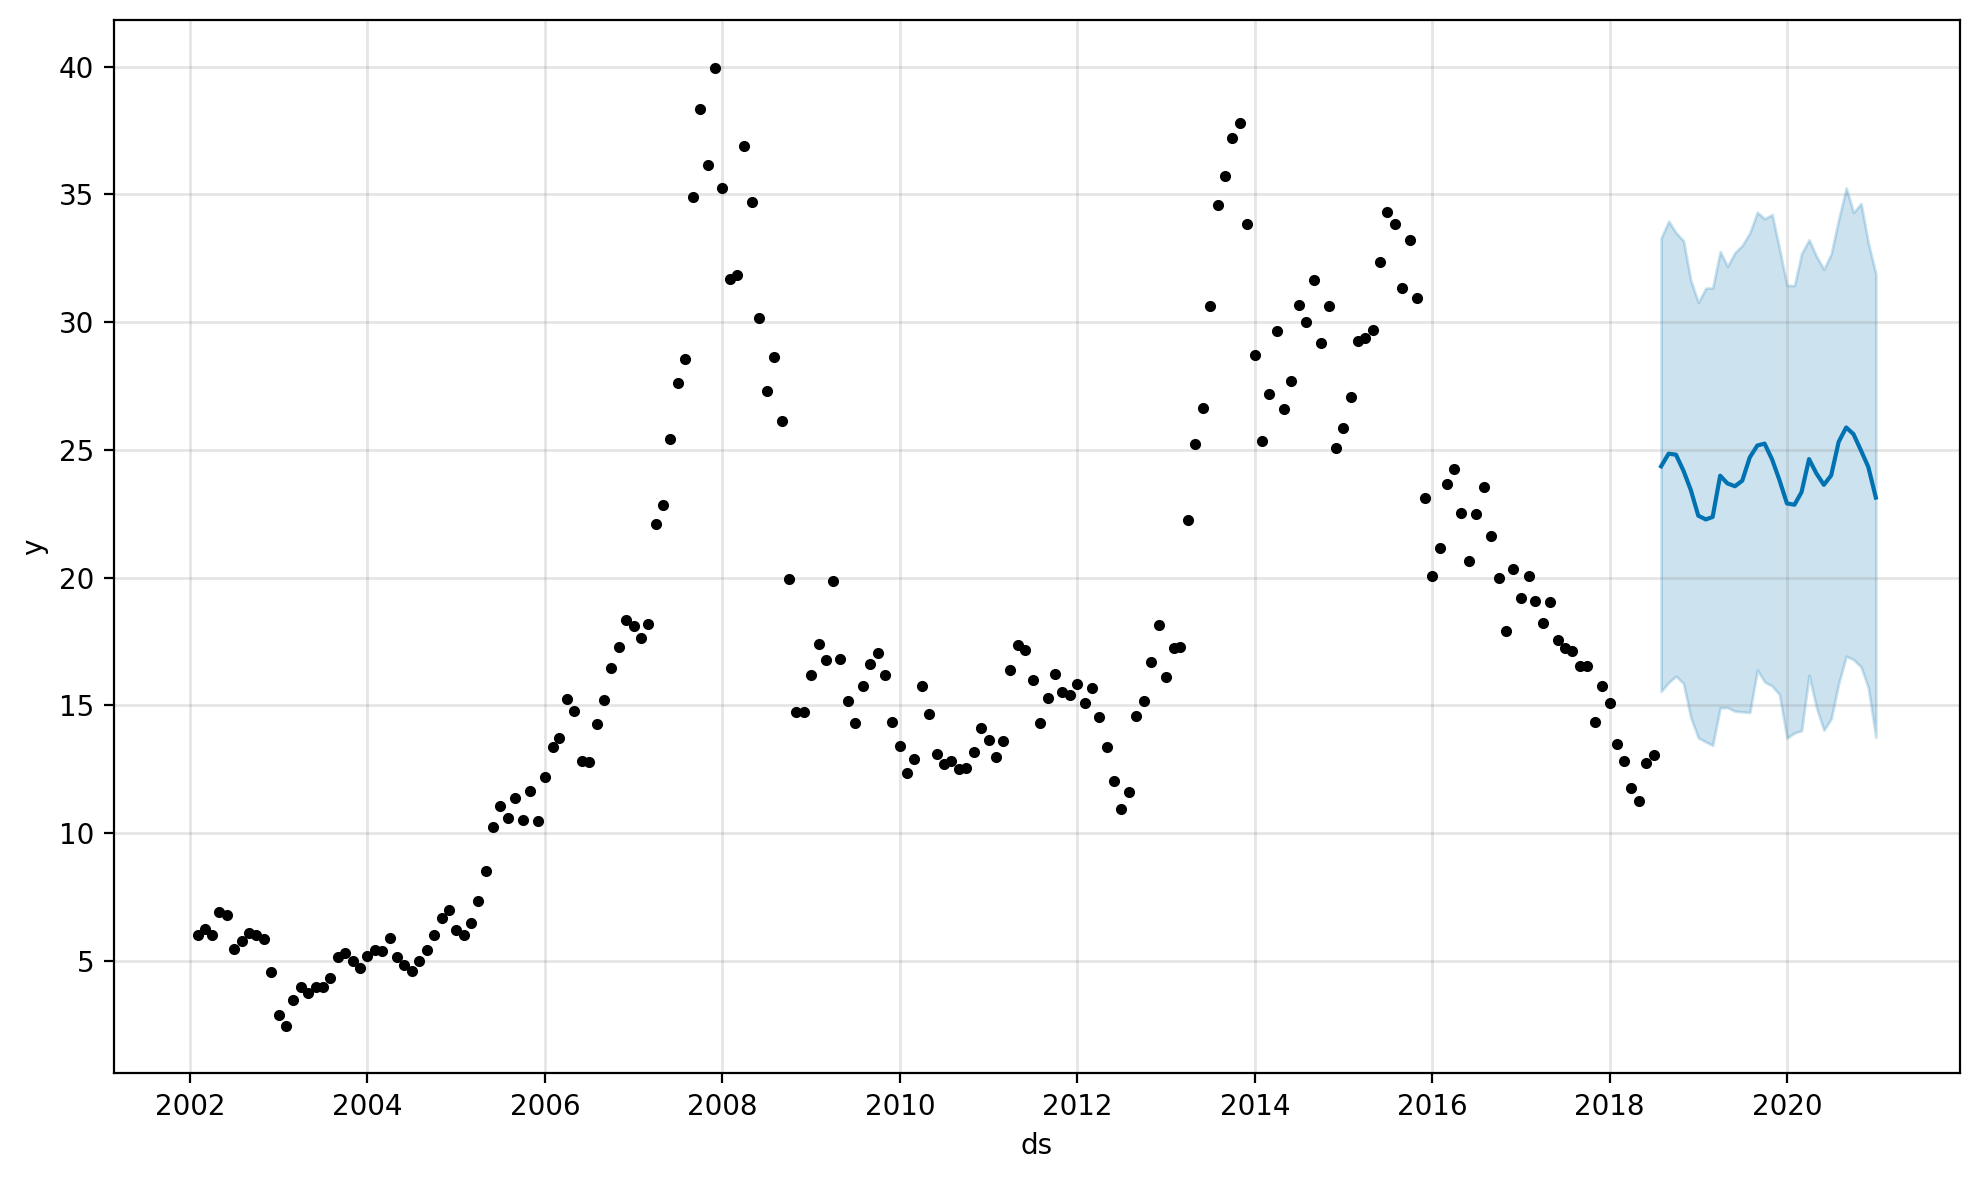

In [263]:
# Prediction Vs Data
fig = prophet.plot(test_prediction)

- We can see that, Prophet couldn't predict well. But it's obivous because of the sharp after 202.
- Let's plot the Pred Vs True

### Predction Vs True Value

In [264]:
#prepare the data for plotting
df_plot_true = df_test.set_index('ds')
df_plot_true.index.name = None

#Set the index as ds and drop name of the index
df_plot_pred = test_prediction[['ds','yhat']].set_index('ds')
df_plot_pred.index.name = None

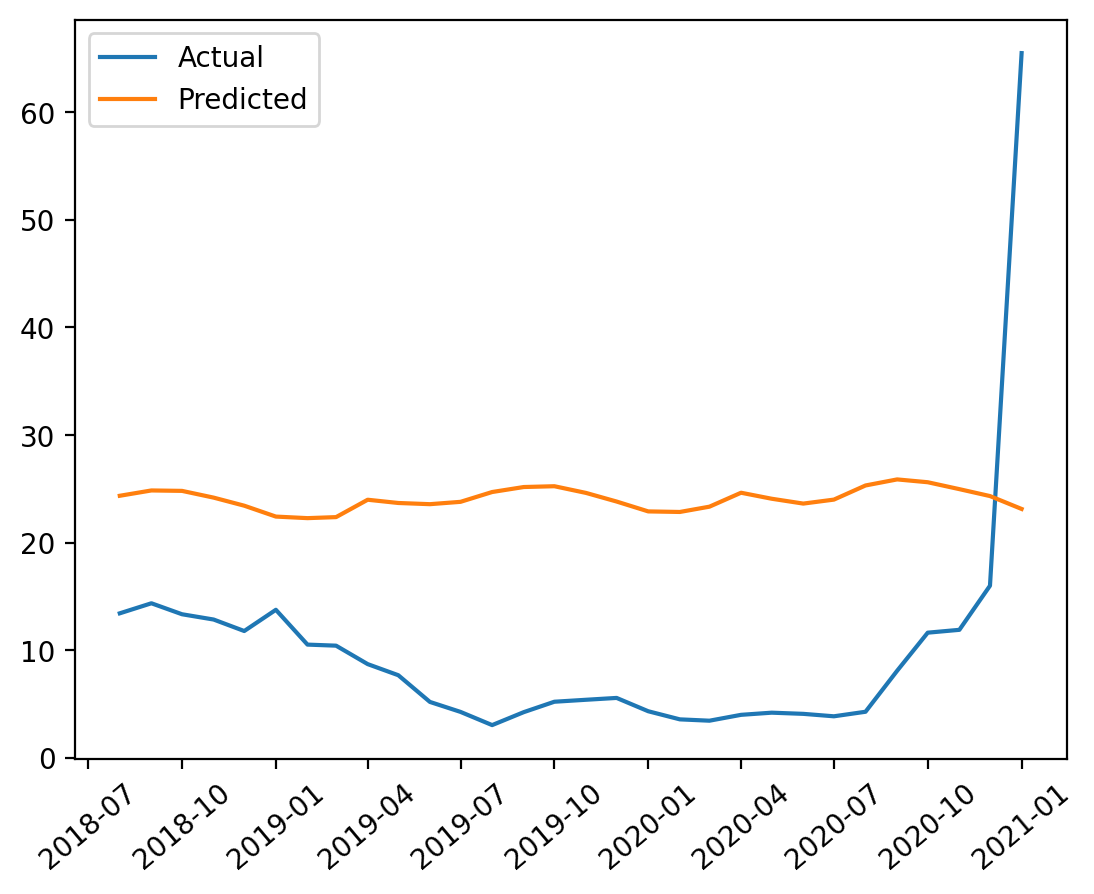

In [265]:
# plot expected vs actual
plt.plot(df_plot_true.y, label='Actual')
plt.plot(df_plot_pred.yhat, label='Predicted')
plt.xticks(rotation=40)
plt.legend();

- We can see that, prophet predcition is a lot better than SARIMAX.

## 2.3) Evaluate the Model

In [266]:
error1 = rmse(df_test.y, test_prediction.yhat)
print(f'Prophet with Sharp RMSE Error: {error1:4.8}')

Prophet with Sharp RMSE Error: 18.175393


In [267]:
df_p['y'].mean()

16.387499519897453

In [268]:
add_score('F-Prophet', rmse(df_test.y, test_prediction.yhat))

,Model,Test
0,F-SARIMAX,11.543219
1,F-Prophet,18.175393


- The RMSE for Prophet equal `+/- 18.175393`, and the mean of adjclose_price is equal `16.3874`.
- The model predict on the data better than SARIMAX, and it's a good prediction for a data with sharp and large difference values across seasons.
- We will focast the next 2.5 year and see the results.

##  2.4) Retrain the model and forecast the future

In [269]:
#Calling Prophet model
prophet = Prophet()

#Fitting the model
prophet.fit(df_p)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [270]:
#Careate a period of 2.5 year
future = pd.DataFrame(data= pd.date_range(start='2/1/2021',end='7/1/2023', freq='MS'), columns=['ds'])
len(future)

30

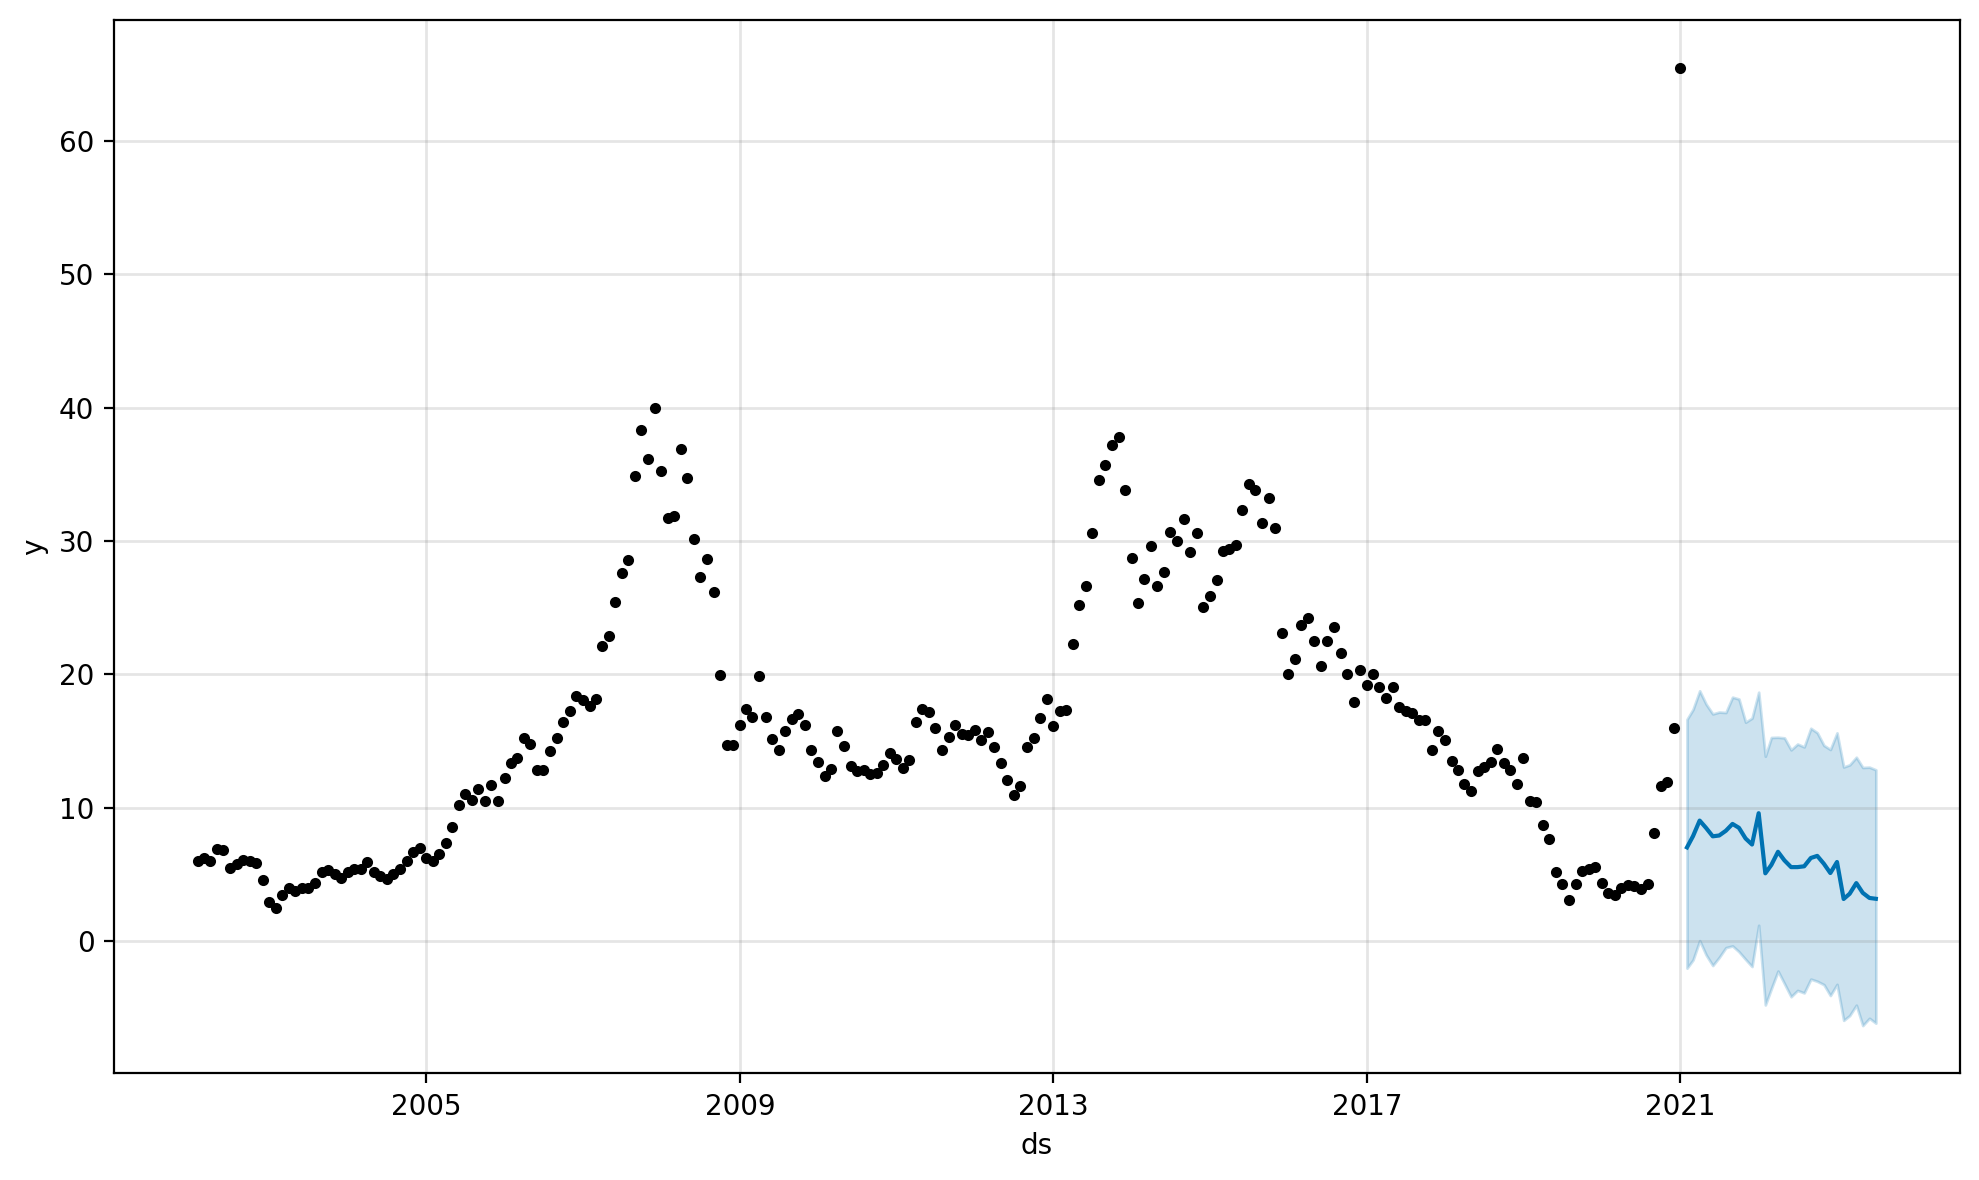

In [271]:
#Forcast the feature
feature_prediction = prophet.predict(future)

fig = prophet.plot(feature_prediction)

- Intresting, that the forcast has been done let say pretty well comparing to SARIMAX, we can't say it's an accurate or good results, but it's better than SARIMAX for sure.

<br><br>

---

<br><br>

<font size='5' color='blue'> Model 3: XGBoost


## Prepare data and functions

####  function  split  dataset into train/test with percent 

In [272]:
def train_test_split(data, perc):
    data = data.values
    n = int(len(data) * (1 - perc))
    return data[:n], data[n:]

####  function  split  train  into X, y 

In [273]:
def split_data(train):
    d = np.array(train)
    X, y = d[:, :-1], d[:, -1]
    return X,y

#### function to fit model 

In [274]:
def xgb_fit_model(data , model):
    # call split_data
    X, y = split_data(data)
    model.fit(X, y)

#### function to get one step predict value

In [275]:
def predict_one_step(data,val):
    #XGBRegressor model
    model = XGBRegressor(eval_metric='rmse', n_estimators=1000)
    
    #call xgb_fit_model 
    xgb_fit_model(data , model)
    
    #predict one step
    val = np.array(val).reshape(1, -1)
    pred = model.predict(val)
    return pred[0]

#### walk-forward validation for data to get all predictions


In [276]:
def walk_forward_predictions(data):
    predictions = []
    train,test=train_test_split(data,0.3)
    
    # fill history with training dataset
    history = [x for x in train]
    

    for i in range(len(test)):
        
        # split test row into X_test, y_test
        X_test, y_test = test[i, :-1], test[i, -1]
        
        # fit model on history && make one_step prediction, using predict_one_step function
        pred_step = predict_one_step(history, X_test[0])
        predictions.append(pred_step)

        # add test[i] to history for the next loop
        history.append(test[i])

    #calculate prediction error
    error = rmse(test[:, -1], predictions)

    return error, test[:, -1], predictions

In [277]:
def walk_forward_predictions_forecast(data, n):
    
    predictions = []
   # train,test=train_test_split(data,0.3)

    d = data.values
    train =  d[:n]
    test = d[n:]
    
    # fill history with training dataset
    history = [x for x in train]
    for i in range(len(test)):
        # split test row into X_test, y_test
        X_test, y_test = test[i, :-1], test[i, -1]
        
        # fit model on history && make one_step prediction using predict_one_step function
        pred_step = predict_one_step(history, X_test[0])
        predictions.append([data.index[n], pred_step])
        # add test[i] to history for the next loop
        history.append(test[i])
        n+=1
            
    return predictions

<br><br>

---

<br><br>

In [278]:
df_XGB_full = rdf[["adjclose_price"]].copy()

In [279]:
df_XGB_full["target"] = df_XGB_full["adjclose_price"].shift(-1)
df_XGB_full.head()

,adjclose_price,target
2002-02-01,6.000000,6.250000
2002-03-01,6.250000,6.000000
2002-04-01,6.000000,6.909091
2002-05-01,6.909091,6.800000
2002-06-01,6.800000,5.454545


## 3.1) check for null values

In [280]:
df_XGB_full.isnull().sum()

adjclose_price    0
target            1
dtype: int64

In [281]:
df_XGB_full.dropna(inplace=True)

## 3.2)  call walk_forward_predictions function

In [282]:
rmse_full, y_full, pred_full = walk_forward_predictions(df_XGB_full)

## 3.3) Predict XGboost model


In [283]:
for i in range(len(pred_full)):
    print(f"predicted={pred_full[i]:4.4}, expected={y_full[i]}")

predicted=29.38, expected=29.7
predicted=26.62, expected=32.36363636363637
predicted=36.91, expected=34.31818181818182
predicted=35.7, expected=33.857142857142854
predicted=28.72, expected=31.333333333333332
predicted=29.18, expected=33.22727272727273
predicted=30.02, expected=30.95
predicted=30.0, expected=23.136363636363637
predicted=25.42, expected=20.05263157894737
predicted=14.74, expected=21.15
predicted=22.86, expected=23.681818181818183
predicted=20.06, expected=24.238095238095237
predicted=24.24, expected=22.523809523809526
predicted=25.23, expected=20.636363636363637
predicted=23.68, expected=22.5
predicted=20.64, expected=23.565217391304348
predicted=24.23, expected=21.61904761904762
predicted=23.68, expected=20.0
predicted=14.74, expected=17.904761904761905
predicted=17.63, expected=20.333333333333332
predicted=21.15, expected=19.2
predicted=16.8, expected=20.05263157894737
predicted=21.15, expected=19.08695652173913
predicted=20.05, expected=18.210526315789473
predicted=22

## 3.4)  Plot Prediction Vs True


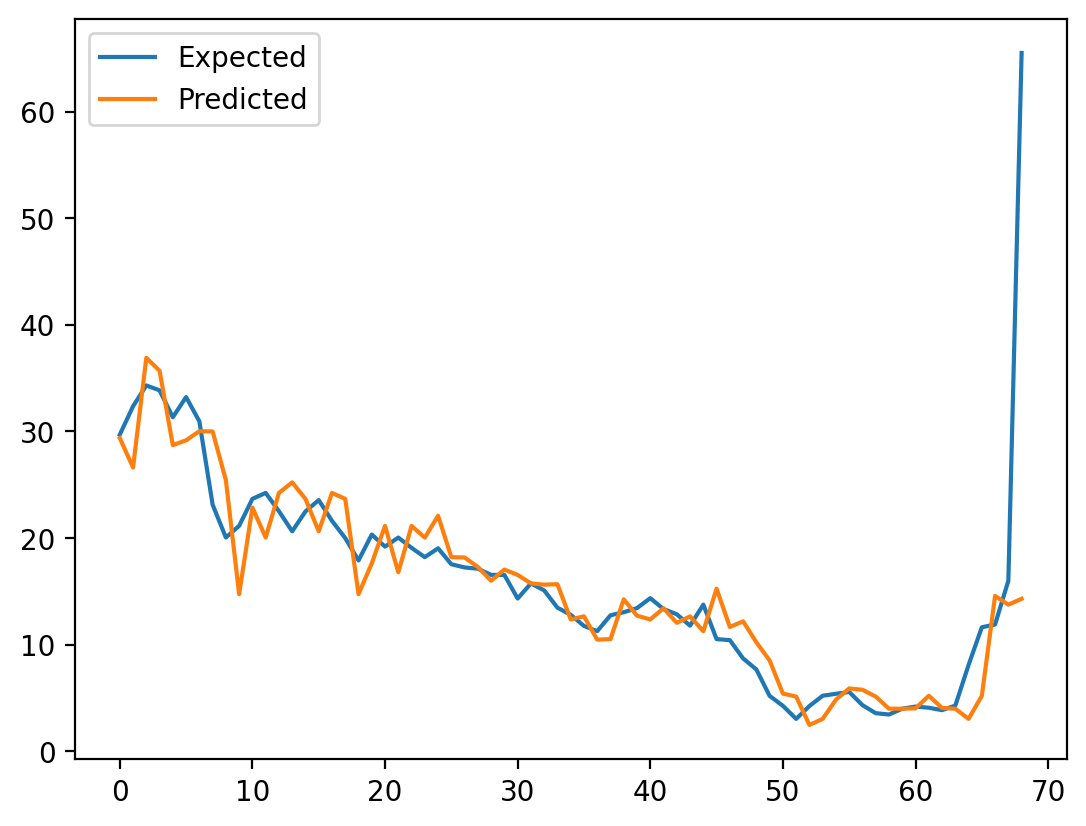

In [284]:
# plot expected vs preducted
plt.plot(y_full, label='Expected')
plt.plot(pred_full, label='Predicted')
plt.legend()
plt.show()

## 3.5)  Evaluate the Model

In [285]:
print("RMSE Error:", rmse_full)

RMSE Error: 6.714643554340737


In [286]:
add_score('F-XGBoost', rmse_full)

,Model,Test
0,F-XGBoost,6.714644
1,F-SARIMAX,11.543219
2,F-Prophet,18.175393


## 3.6) Retrain the model and forecast the future

In [368]:
#Careate a period of 2.5 year
future = pd.DataFrame(data= pd.date_range(start='1/1/2021',end='6/1/2023', freq='MS'), columns=['ds'])
len(future)

30

In [369]:
future["adjclose_price"]=0
future["target"]=0
future.set_index('ds',inplace=True)
future.index.name = None

In [370]:
forecast_XGB_full = pd.concat([df_XGB_full, future])

In [371]:
forecast_XGB_full["target"] = forecast_XGB_full["adjclose_price"].shift(-1)

In [372]:
forecast_XGB_full

,adjclose_price,target
2002-02-01,6.000000,6.250000
2002-03-01,6.250000,6.000000
2002-04-01,6.000000,6.909091
2002-05-01,6.909091,6.800000
2002-06-01,6.800000,5.454545
2002-07-01,5.454545,5.772727
2002-08-01,5.772727,6.100000
2002-09-01,6.100000,6.000000
2002-10-01,6.000000,5.850000
2002-11-01,5.850000,4.571429


In [373]:
forecast_XGB_full.dropna(inplace=True)

In [374]:
XGB_forcast = pd.DataFrame(walk_forward_predictions_forecast(forecast_XGB_full, len(df_XGB_full)),
                           columns=['date', 'target']).set_index('date')
XGB_forcast.index.name = None
XGB_forcast

,target
2021-01-01,3.475794
2021-02-01,0.001216
2021-03-01,0.000715
2021-04-01,0.000553
2021-05-01,0.000060
2021-06-01,0.000012
2021-07-01,0.000234
2021-08-01,0.000051
2021-09-01,0.000273
2021-10-01,0.000047


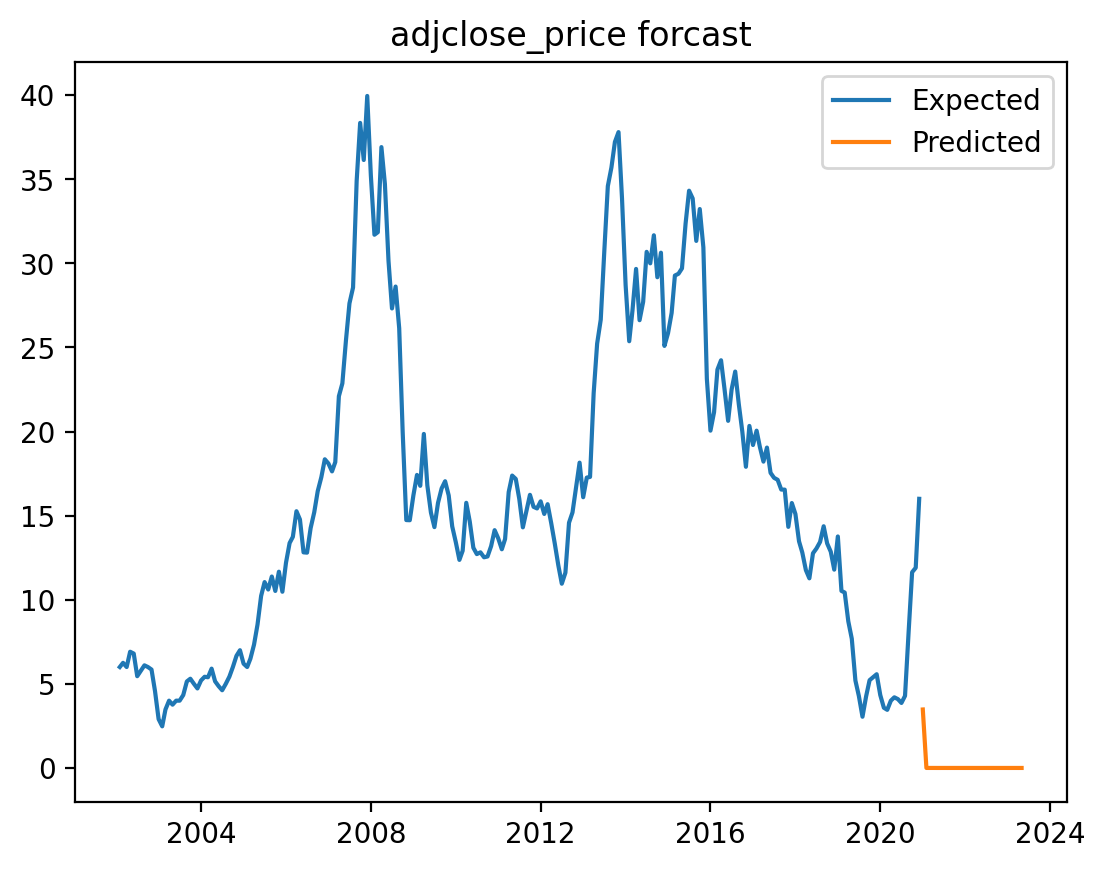

In [363]:
# # Plot predictions against known values

plt.title('adjclose_price forcast')

# plot expected vs preducted
plt.plot(df_XGB_full['adjclose_price'], label='Expected')

plt.plot(XGB_forcast.target, label='Predicted')

plt.legend()

plt.show()

<br><br>

---

<br><br>

<center> <font size='6' color='green'> Data modeling to the end of 2020

In [295]:
df_no_sharp = df[:-18]
df_no_sharp = df_no_sharp.resample('MS').mean()
df_no_sharp.tail()

,open_price,high_price,low_price,close_price,total_volume,adjclose_price
2020-08-01,4.190476,4.428571,4.142857,4.285714,5.584324e+06,4.285714
2020-09-01,7.952381,8.428571,7.571429,8.095238,1.213639e+07,8.095238
2020-10-01,11.590909,12.409091,11.227273,11.636364,1.635780e+07,11.636364
2020-11-01,11.850000,12.500000,11.400000,11.900000,8.074540e+06,11.900000
2020-12-01,16.045455,16.954545,15.409091,16.000000,1.142264e+07,16.000000


In [296]:
df_train_s = df_no_sharp.adjclose_price.iloc[:-30]
df_test_s = df_no_sharp.adjclose_price.iloc[-30:] 

In [297]:
df_train_s.tail()

2018-02-01    13.473684
2018-03-01    12.809524
2018-04-01    11.761905
2018-05-01    11.272727
2018-06-01    12.761905
Freq: MS, Name: adjclose_price, dtype: float64

- df_train_s and df_test_s is without the sharp after 2020.

## Auto-ARIMA

In [298]:
auto_fit = auto_arima(df_no_sharp['adjclose_price'],
           seasonal=True,
           m=30)      

auto_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  227
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -461.237
Date:                Wed, 10 Feb 2021   AIC                            926.474
Time:                        15:20:40   BIC                            933.315
Sample:                             0   HQIC                           929.235
                                - 227                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2485      0.046      5.460      0.000       0.159       0.338
sigma2         3.4680      0.234     14.794      0.000       3.009       3.927
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                38.97
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                            -0.36
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<br><br>

---

<br><br>

In [299]:
df_train_s.shape , df_test_s.shape

((197,), (30,))

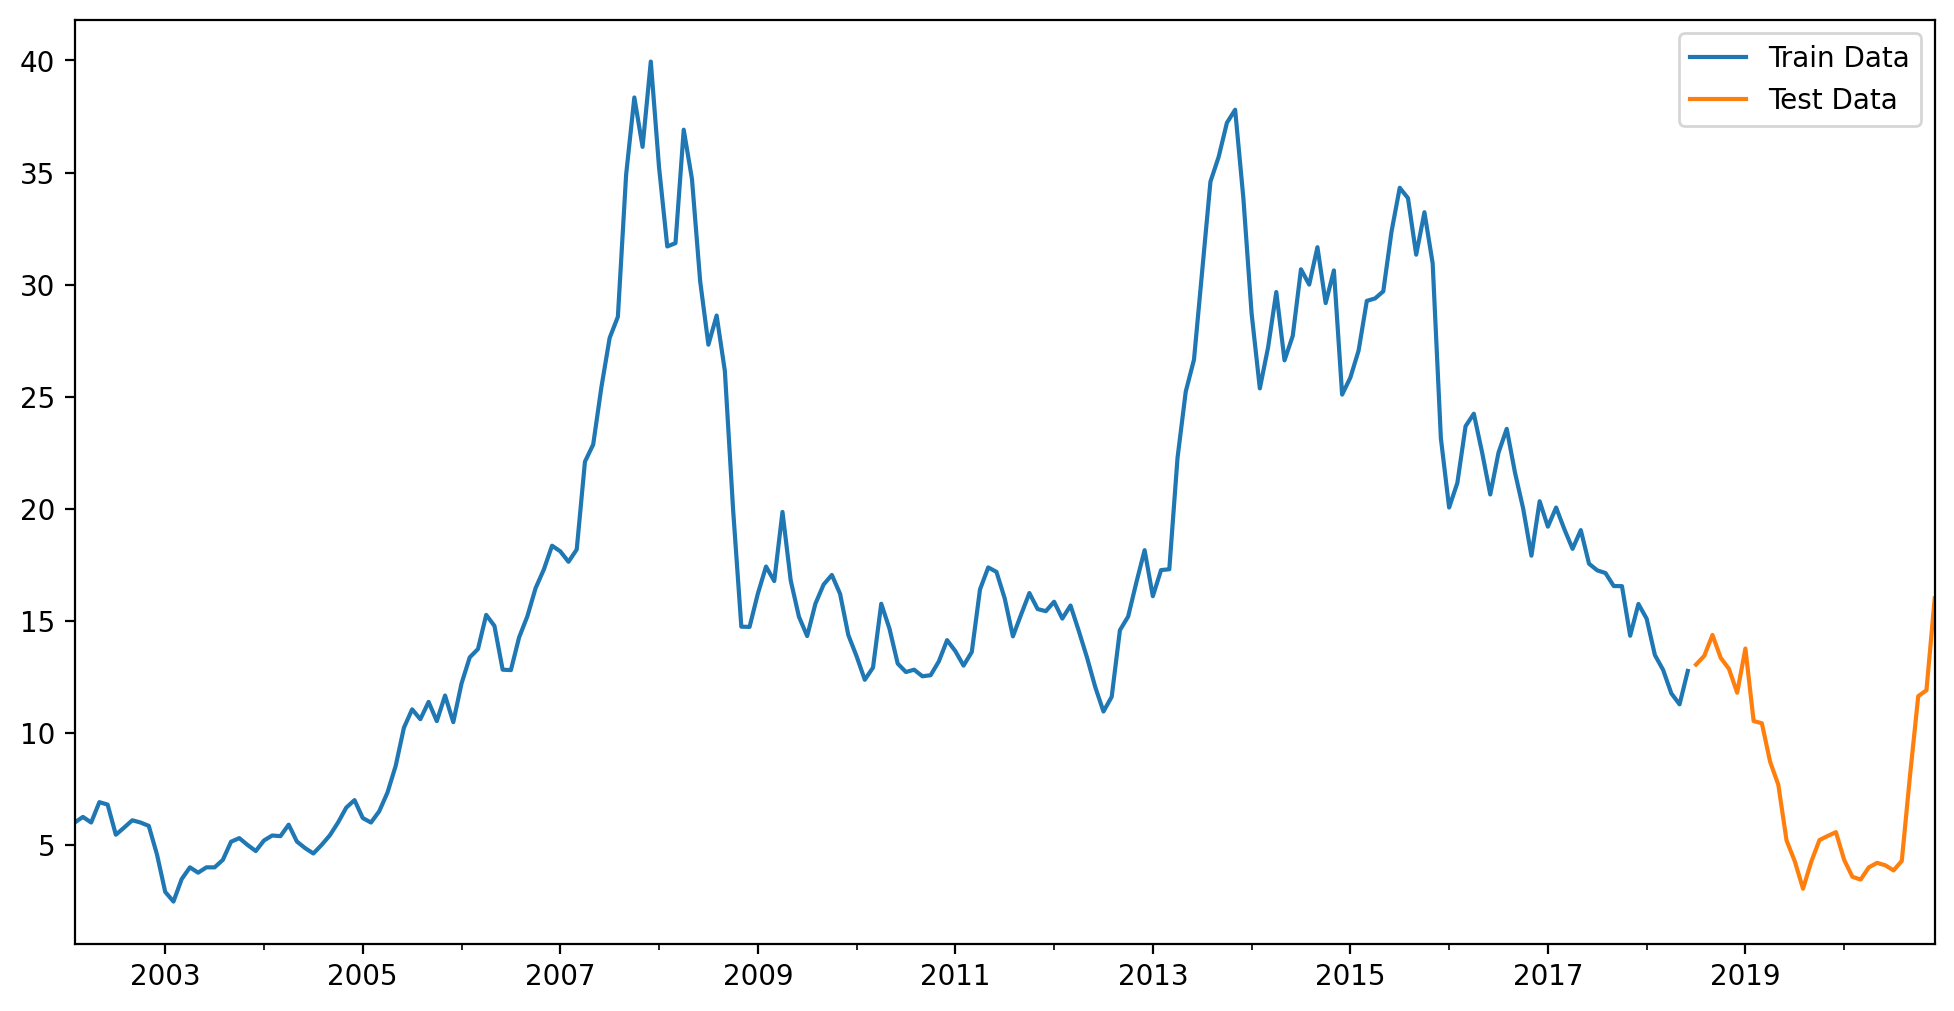

In [300]:
# Plot the train and test sets on the axis ax
fig, ax = plt.subplots(figsize=(12,6))

df_train_s.plot(ax=ax)
df_test_s.plot(ax=ax)

ax.legend(labels=['Train Data','Test Data']);

<br><br>

---

<br><br>

<font size='5' color='blue'> Model 1: SARIMAX

In [301]:
model1 = SARIMAX(df_train_s,
                 order=(0,1,1))

results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         adjclose_price   No. Observations:                  197
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -403.720
Date:                Wed, 10 Feb 2021   AIC                            811.439
Time:                        15:20:41   BIC                            817.995
Sample:                    02-01-2002   HQIC                           814.093
                         - 06-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2629      0.048      5.504      0.000       0.169       0.356
sigma2         3.6015      0.261     13.791      0.000       3.090       4.113
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                35.46
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.42   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 1.1) Predict SARIMAX model

In [302]:
#Obtain predicted values
start = len(df_train_s)
end = len(df_train_s) + len(df_test_s)-1

In [303]:
predictions = results1.predict(start = start,
                                end = end,
                                dynamic = False,
                                typ = 'levels').rename('SARIMA(0,1,1)')

In [304]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted = {predictions[i]:4.4}, expected = {df_train_s[i]}")

predicted = 13.17, expected = 6.0
predicted = 13.17, expected = 6.25
predicted = 13.17, expected = 6.0
predicted = 13.17, expected = 6.909090909090909
predicted = 13.17, expected = 6.8
predicted = 13.17, expected = 5.454545454545454
predicted = 13.17, expected = 5.7727272727272725
predicted = 13.17, expected = 6.1
predicted = 13.17, expected = 6.0
predicted = 13.17, expected = 5.85
predicted = 13.17, expected = 4.571428571428571
predicted = 13.17, expected = 2.9047619047619047
predicted = 13.17, expected = 2.473684210526316
predicted = 13.17, expected = 3.4761904761904763
predicted = 13.17, expected = 4.0
predicted = 13.17, expected = 3.761904761904762
predicted = 13.17, expected = 4.0
predicted = 13.17, expected = 4.0
predicted = 13.17, expected = 4.333333333333333
predicted = 13.17, expected = 5.142857142857143
predicted = 13.17, expected = 5.304347826086956
predicted = 13.17, expected = 5.0
predicted = 13.17, expected = 4.7272727272727275
predicted = 13.17, expected = 5.2
predicted 

## 1.2) Plot Prediction Vs True

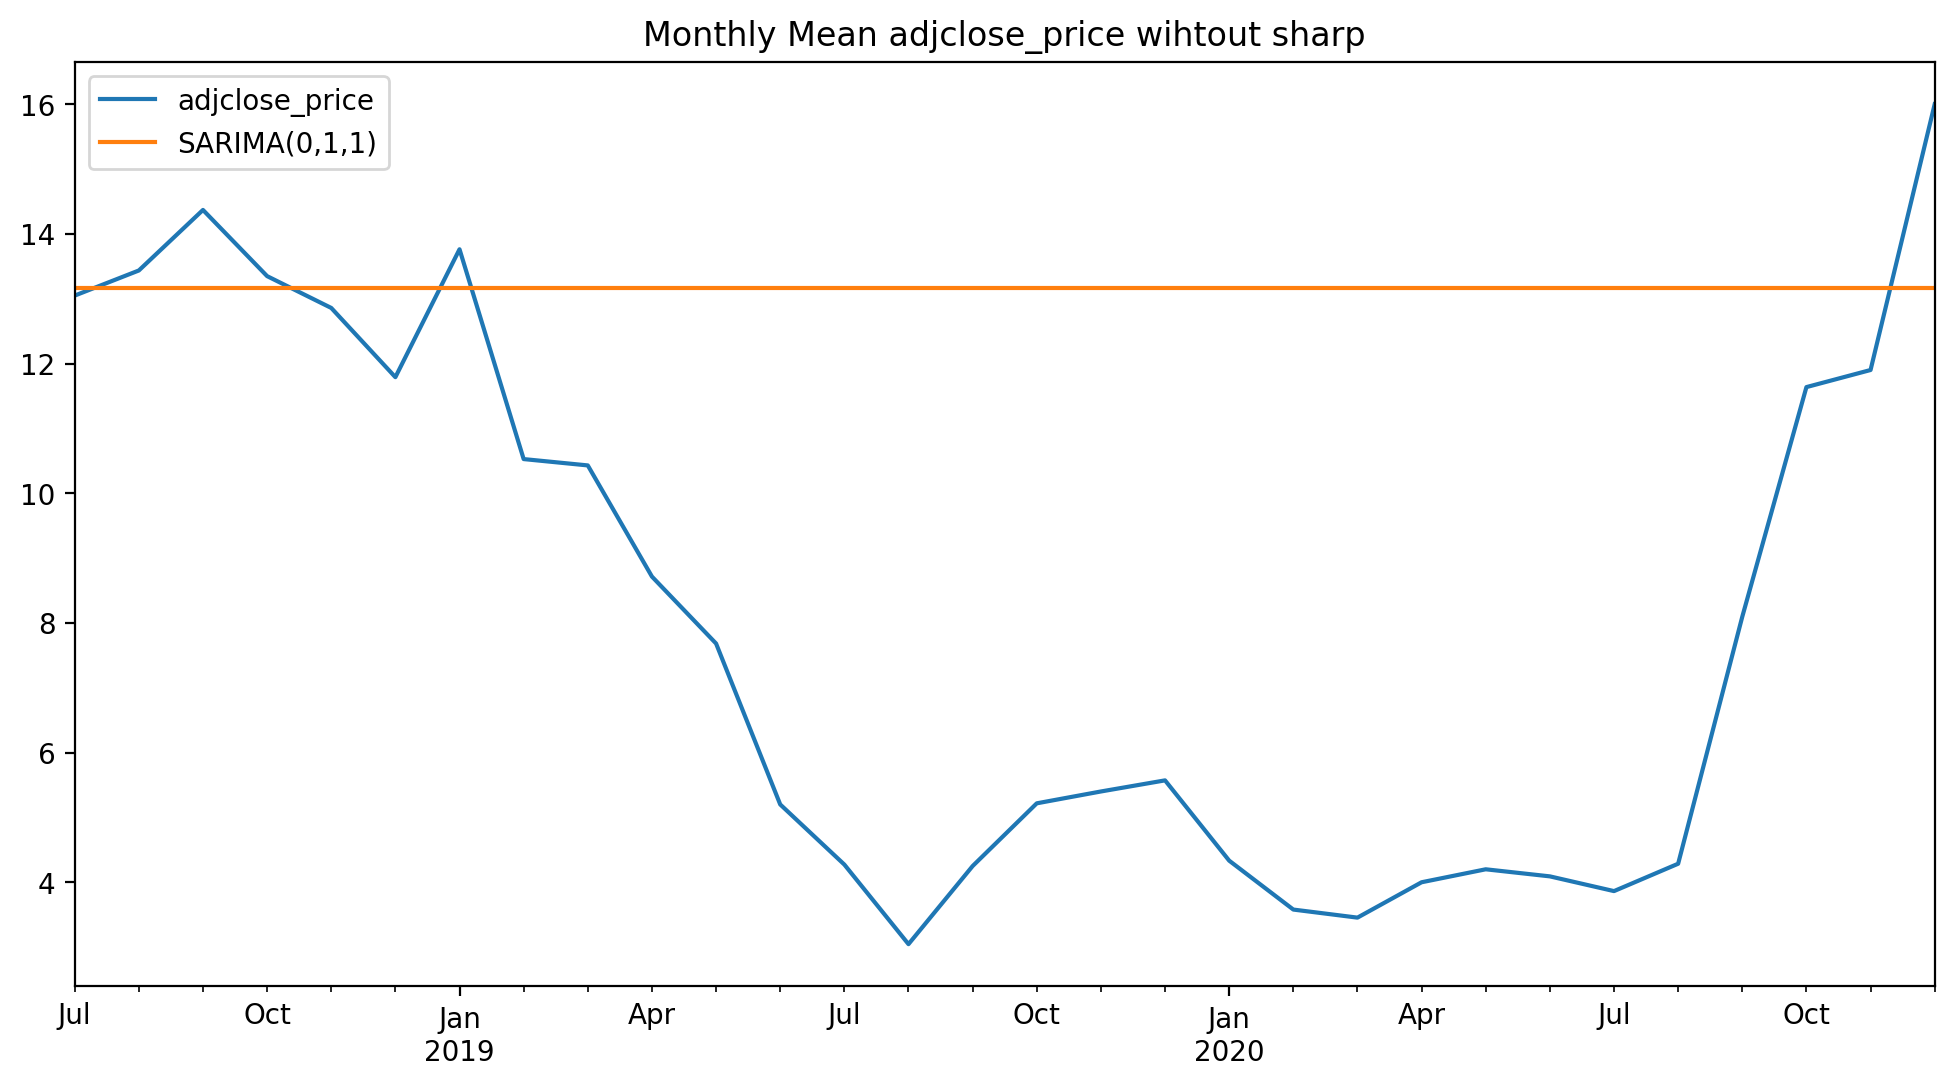

In [305]:
# Plot predictions against known values
title = 'Monthly Mean adjclose_price wihtout sharp'

ax = df_test_s.plot(legend=True, figsize=(12,6), title=title)

predictions.plot(legend=True)

ax.autoscale(axis='x', tight=True)

## 1.3) Evaluate the Model

In [306]:
error1 = rmse(df_test_s, predictions)
print(f'SARIMAX (0, 1, 1) RMSE Error: {error1:4.8}')

SARIMAX (0, 1, 1) RMSE Error: 6.5551366


In [307]:
df_no_sharp['adjclose_price'].mean()

16.1711448922318

In [308]:
add_score('SARIMAX', rmse(df_test_s, predictions))

,Model,Test
0,SARIMAX,6.555137
1,F-XGBoost,6.714644
2,F-SARIMAX,11.543219
3,F-Prophet,18.175393


- The RMSE for SARIMAX wihtout teh sahrp equal `+/- 6.5558`, and the mean of adjclose_price is equal `16.34569`.
- The model also couldn't predict on the data very well, but it's better than predicting with the sharp data.
- The RMSE is better than the RMSE with sharp that we got before `11.543219`.
- Also model used the mean as prediction for the test data.
- We will focast the next 2.5 year and see the results.

##  1.4) Retrain the model and forecast the future

In [309]:
model = SARIMAX(df_no_sharp['adjclose_price'],
                order=(0,1,1))

results = model.fit()

fcast = results.predict(len(df_no_sharp),
                        len(df_no_sharp) + 30,
                        typ='levels').rename('SARIMA(0,1,1) Forecast')

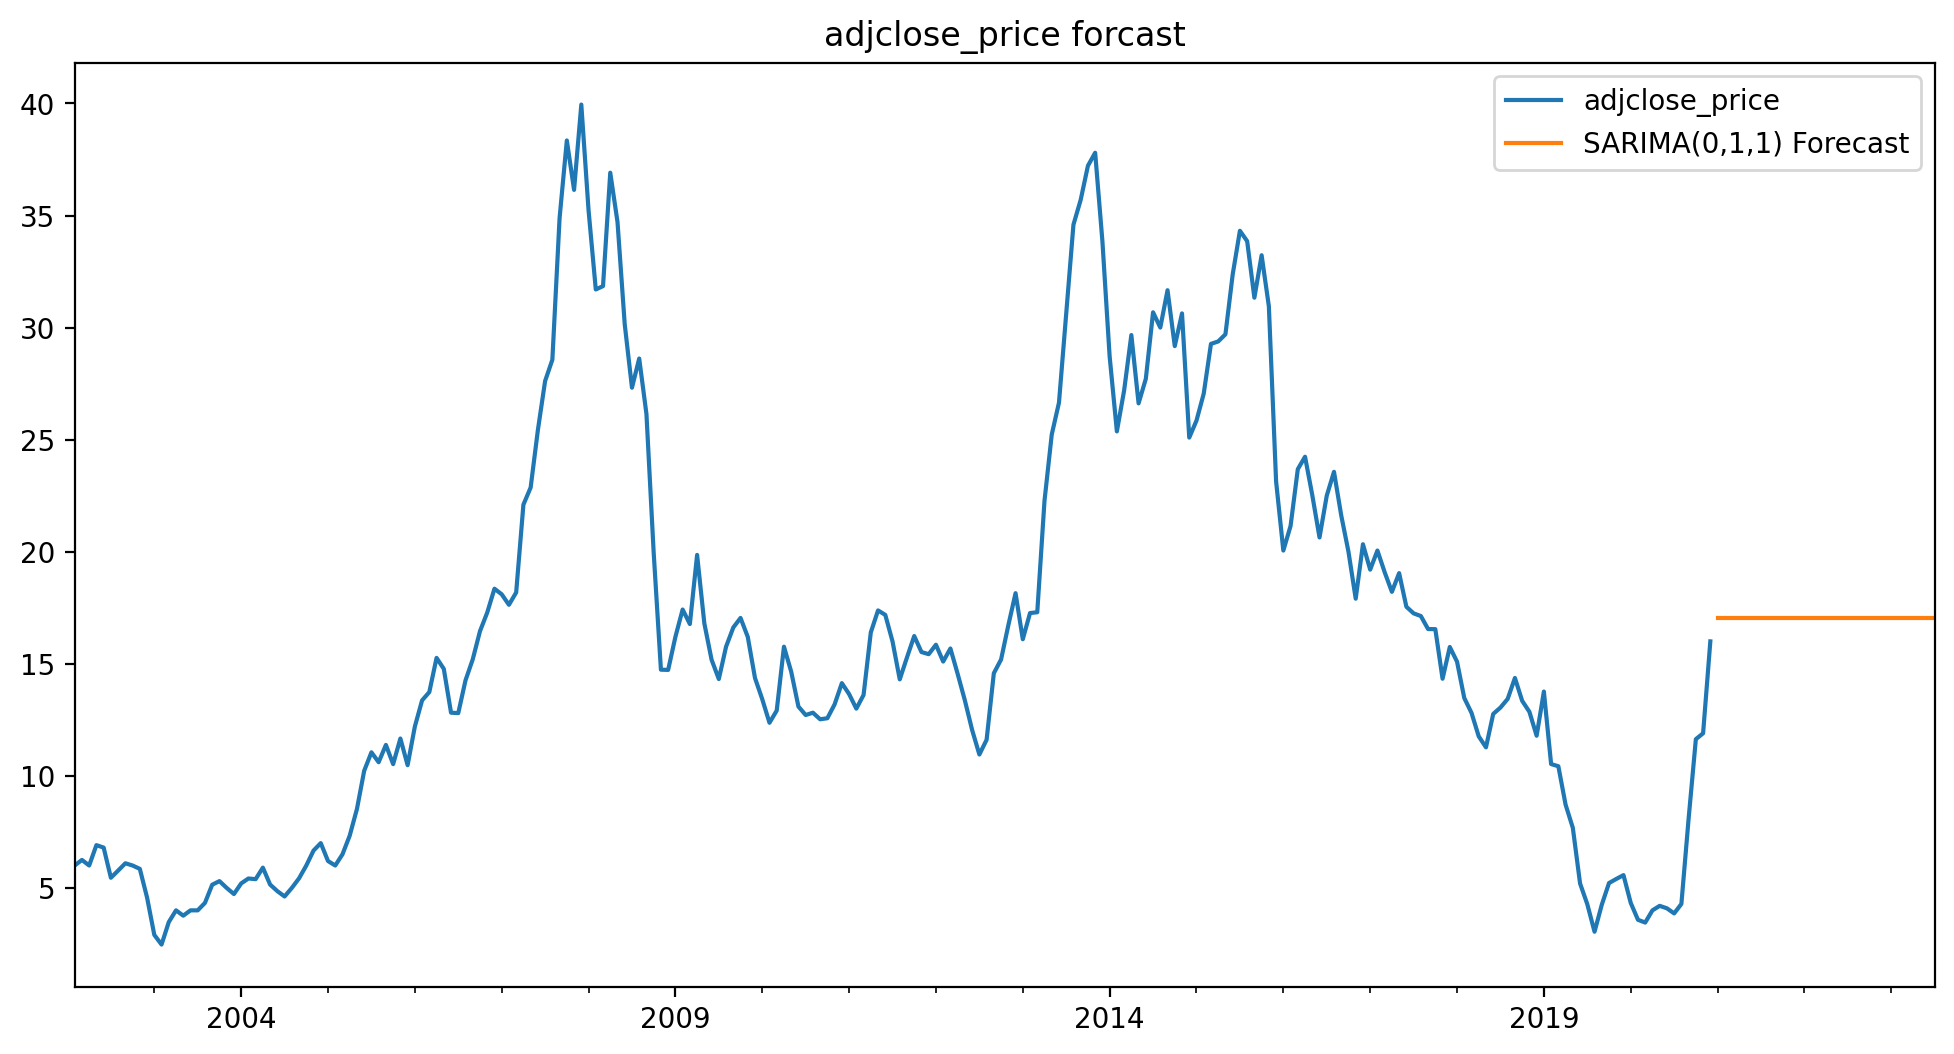

In [310]:
# Plot predictions against known values
title = 'adjclose_price forcast'

ax = df_no_sharp['adjclose_price'].plot(legend=True,
                                        figsize=(12,6),
                                        title=title)
fcast.plot(legend=True)

ax.autoscale(axis='x',
             tight=True)

- Same as previous.

<br><br>

----

<br><br>

<font size='5' color='blue'> Model 2: Facebook Prophet

In [311]:
df_no_sharp.tail()

,open_price,high_price,low_price,close_price,total_volume,adjclose_price
2020-08-01,4.190476,4.428571,4.142857,4.285714,5.584324e+06,4.285714
2020-09-01,7.952381,8.428571,7.571429,8.095238,1.213639e+07,8.095238
2020-10-01,11.590909,12.409091,11.227273,11.636364,1.635780e+07,11.636364
2020-11-01,11.850000,12.500000,11.400000,11.900000,8.074540e+06,11.900000
2020-12-01,16.045455,16.954545,15.409091,16.000000,1.142264e+07,16.000000


## Prepare data

In [312]:
#Prepare the data for Facebook Prophet model

#Get the predictor and reset index to get the date
df_prophet = df_no_sharp[['adjclose_price']].reset_index()

#Rename the index to ds and predictor to y. 
#It's a must for this model
df_prophet.rename(columns={'index':'ds',
                   'adjclose_price':'y'},
          inplace=True)

#Print the head to check
df_prophet.tail()

,ds,y
222,2020-08-01,4.285714
223,2020-09-01,8.095238
224,2020-10-01,11.636364
225,2020-11-01,11.900000
226,2020-12-01,16.000000


## Split data to train and test

In [313]:
#Split data to train and test, taking one session = 2.5 year 
df_train_p = df_prophet.iloc[:-30]
df_test_p = df_prophet.iloc[-30:] 

In [314]:
df_train_p.tail()

,ds,y
192,2018-02-01,13.473684
193,2018-03-01,12.809524
194,2018-04-01,11.761905
195,2018-05-01,11.272727
196,2018-06-01,12.761905


In [315]:
df_test_p.tail()

,ds,y
222,2020-08-01,4.285714
223,2020-09-01,8.095238
224,2020-10-01,11.636364
225,2020-11-01,11.900000
226,2020-12-01,16.000000


##  Prophet

In [316]:
#Calling Prophet model
prophet = Prophet()

#Fitting the model
prophet.fit(df_train_p)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 2.1) Predict Prophet model

In [317]:
test_prediction = prophet.predict(df_test_p)

In [318]:
# Compare predictions to expected values
for i in range(len(test_prediction)):
    print(f'predicted = {test_prediction.yhat.iloc[i]:4.3} | expected = {df_test_p.y.iloc[i]:4.3}')

predicted = 24.3 | expected = 13.0
predicted = 24.7 | expected = 13.4
predicted = 25.1 | expected = 14.4
predicted = 25.1 | expected = 13.3
predicted = 24.5 | expected = 12.9
predicted = 23.8 | expected = 11.8
predicted = 22.8 | expected = 13.8
predicted = 22.6 | expected = 10.5
predicted = 22.7 | expected = 10.4
predicted = 24.2 | expected = 8.71
predicted = 24.0 | expected = 7.68
predicted = 23.9 | expected =  5.2
predicted = 24.9 | expected = 4.27
predicted = 25.0 | expected = 3.05
predicted = 25.5 | expected = 4.25
predicted = 25.6 | expected = 5.22
predicted = 25.0 | expected =  5.4
predicted = 24.2 | expected = 5.57
predicted = 23.4 | expected = 4.33
predicted = 23.2 | expected = 3.58
predicted = 23.8 | expected = 3.45
predicted = 25.0 | expected =  4.0
predicted = 24.5 | expected =  4.2
predicted = 24.1 | expected = 4.09
predicted = 25.0 | expected = 3.86
predicted = 25.8 | expected = 4.29
predicted = 26.3 | expected =  8.1
predicted = 26.1 | expected = 11.6
predicted = 25.4 | e

## 2.2) Plot Prediction Vs True

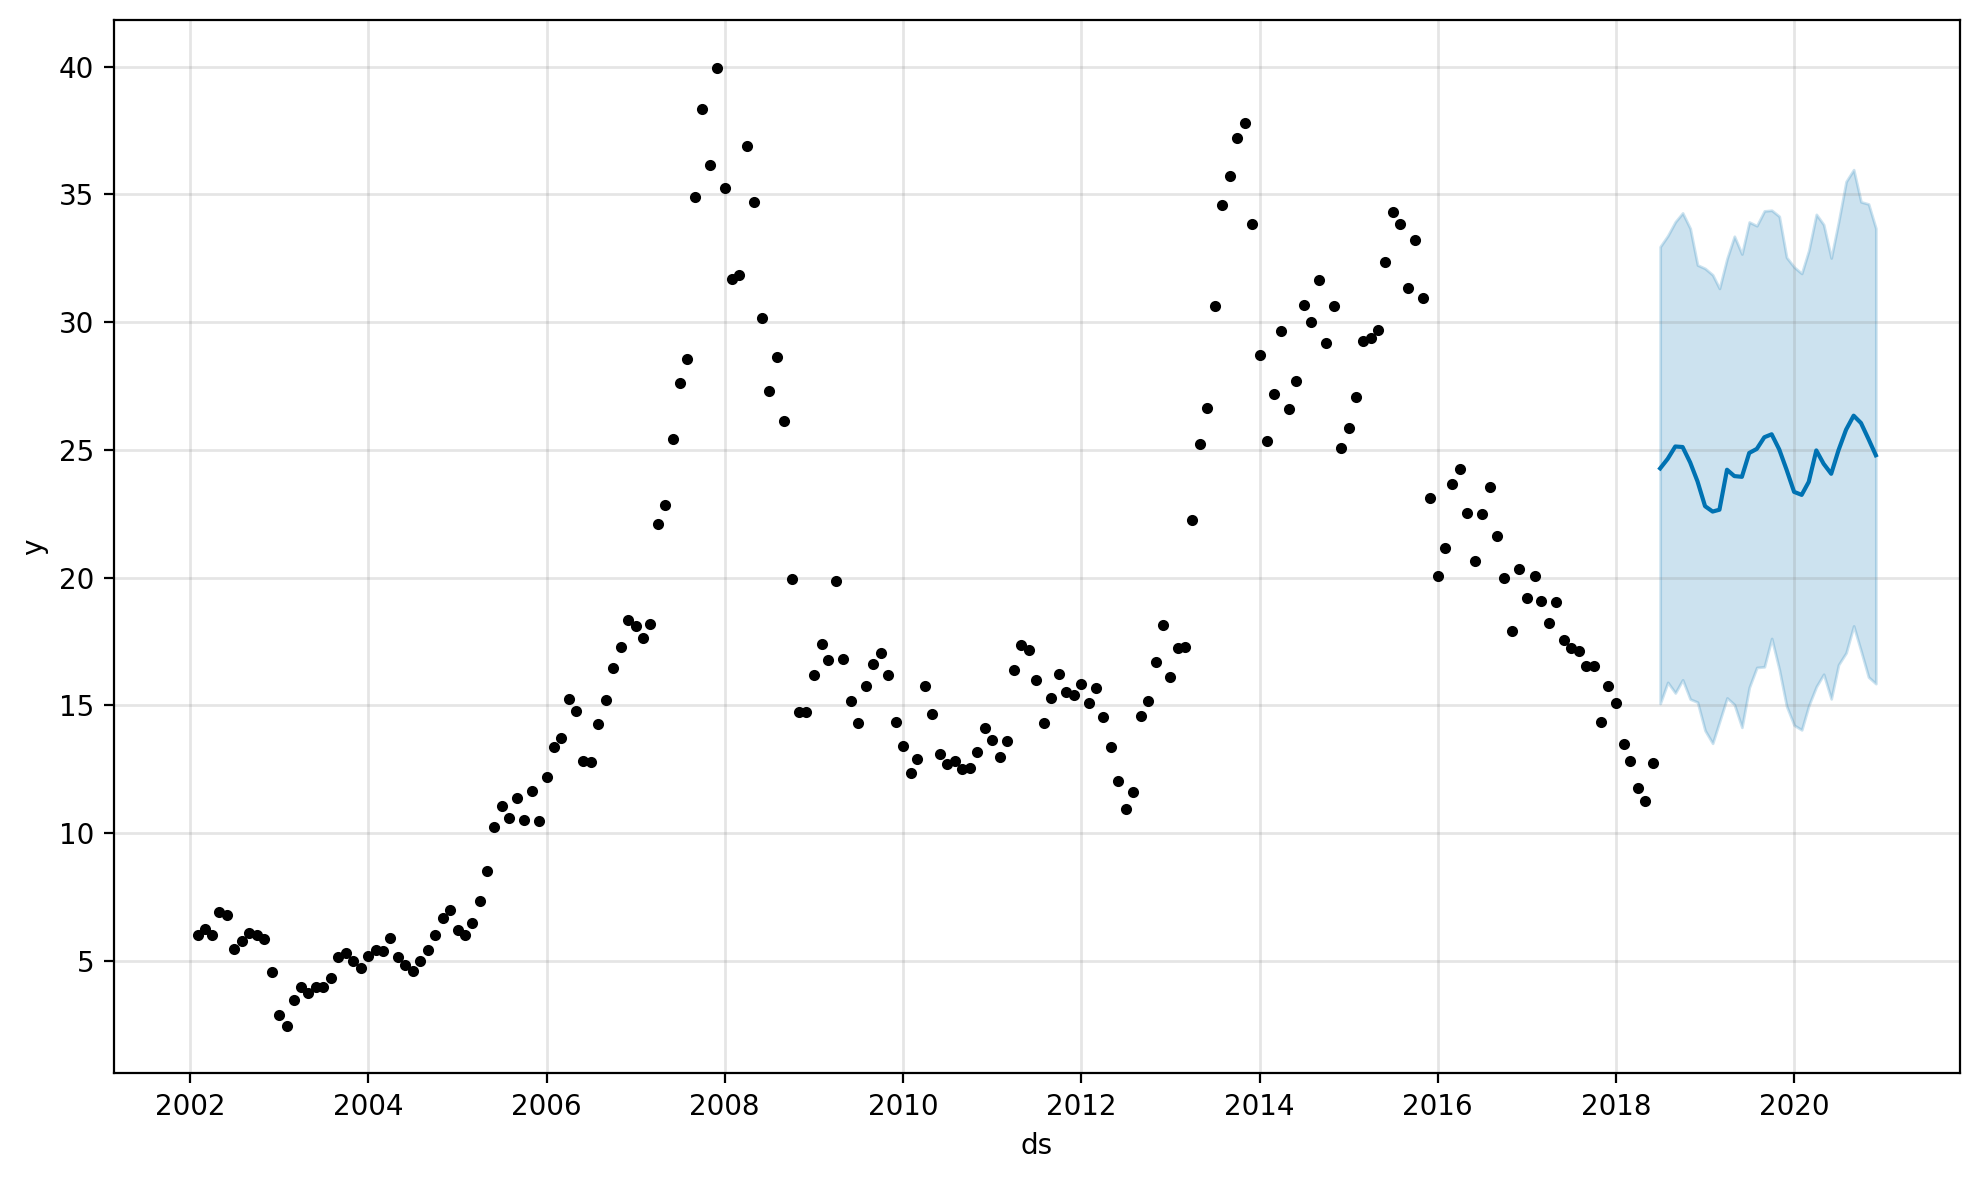

In [319]:
# Prediction Vs Data
fig = prophet.plot(test_prediction)

- Let's plot the Pred Vs True to decide.

### Predction Vs True Value

In [320]:
#prepare the data for plotting
df_plot_true_p = df_test_p.set_index('ds')
df_plot_true_p.index.name = None

#Set the index as ds and drop name of the index
df_plot_pred_p = test_prediction[['ds','yhat']].set_index('ds')
df_plot_pred_p.index.name = None

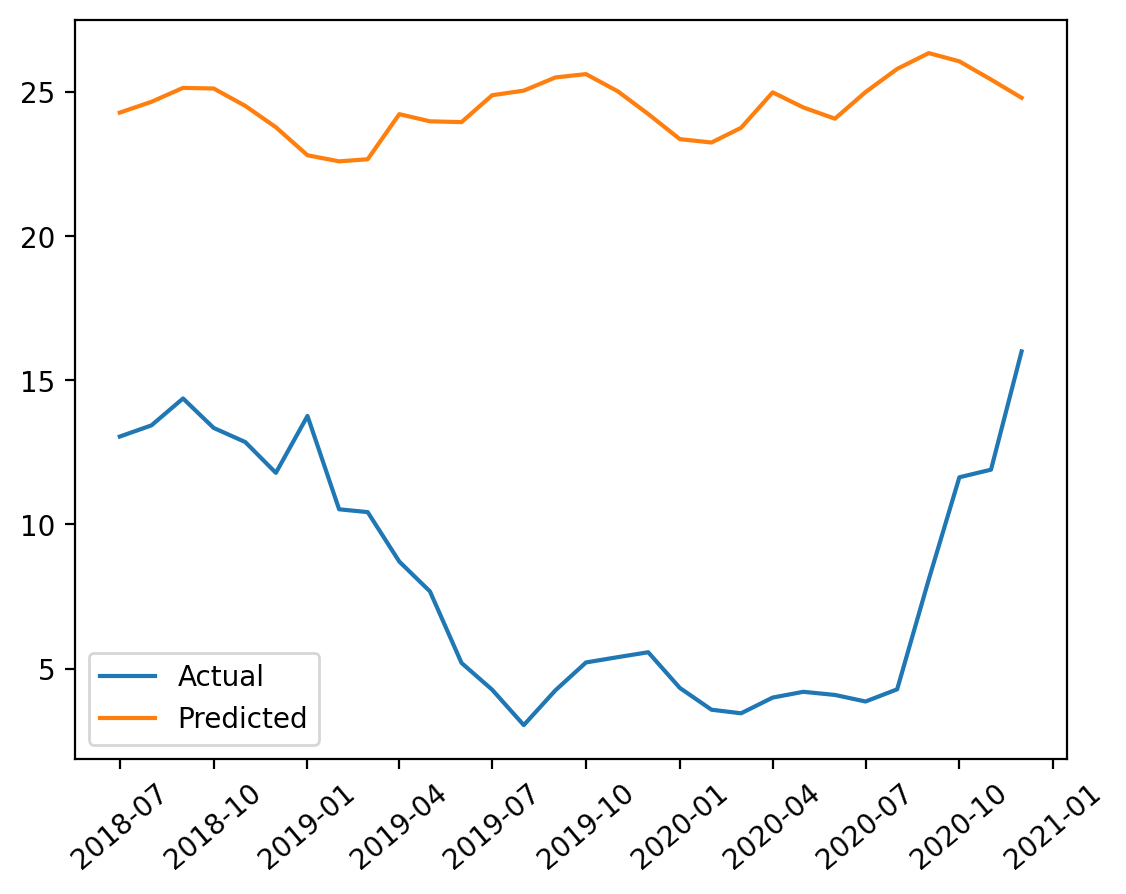

In [321]:
# plot expected vs actual
plt.plot(df_plot_true_p.y, label='Actual')
plt.plot(df_plot_pred_p.yhat, label='Predicted')
plt.xticks(rotation=40)
plt.legend();

- We can see that, prophet predcition is a lot better than SARIMAX.

## 2.3) Evaluate the Model

In [322]:
error1 = rmse(df_test.y, test_prediction.yhat)
print(f'Prophet with Sharp RMSE Error: {error1:4.8}')

Prophet with Sharp RMSE Error: 18.362436


In [323]:
df_no_sharp['adjclose_price'].mean()

16.1711448922318

In [324]:
add_score('Prophet',rmse(df_test.y, test_prediction.yhat))

,Model,Test
0,SARIMAX,6.555137
1,F-XGBoost,6.714644
2,F-SARIMAX,11.543219
3,F-Prophet,18.175393
4,Prophet,18.362436


- The RMSE for Prophet equal `+/- 18.175393`, and the mean of adjclose_price is equal `16.3874`.
- The model predict on the data better than SARIMAX, and it's a good prediction for a data with sharp and large difference values across seasons.
- We will focast the next 2.5 year and see the results.

##  2.4) Retrain the model and forecast the future

In [325]:
#Calling Prophet model
prophet = Prophet()

#Fitting the model
prophet.fit(df_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [326]:
#Careate a period of 2.5 year
future = pd.DataFrame(data= pd.date_range(start='1/1/2021',end='6/1/2023', freq='MS'), columns=['ds'])
len(future)

30

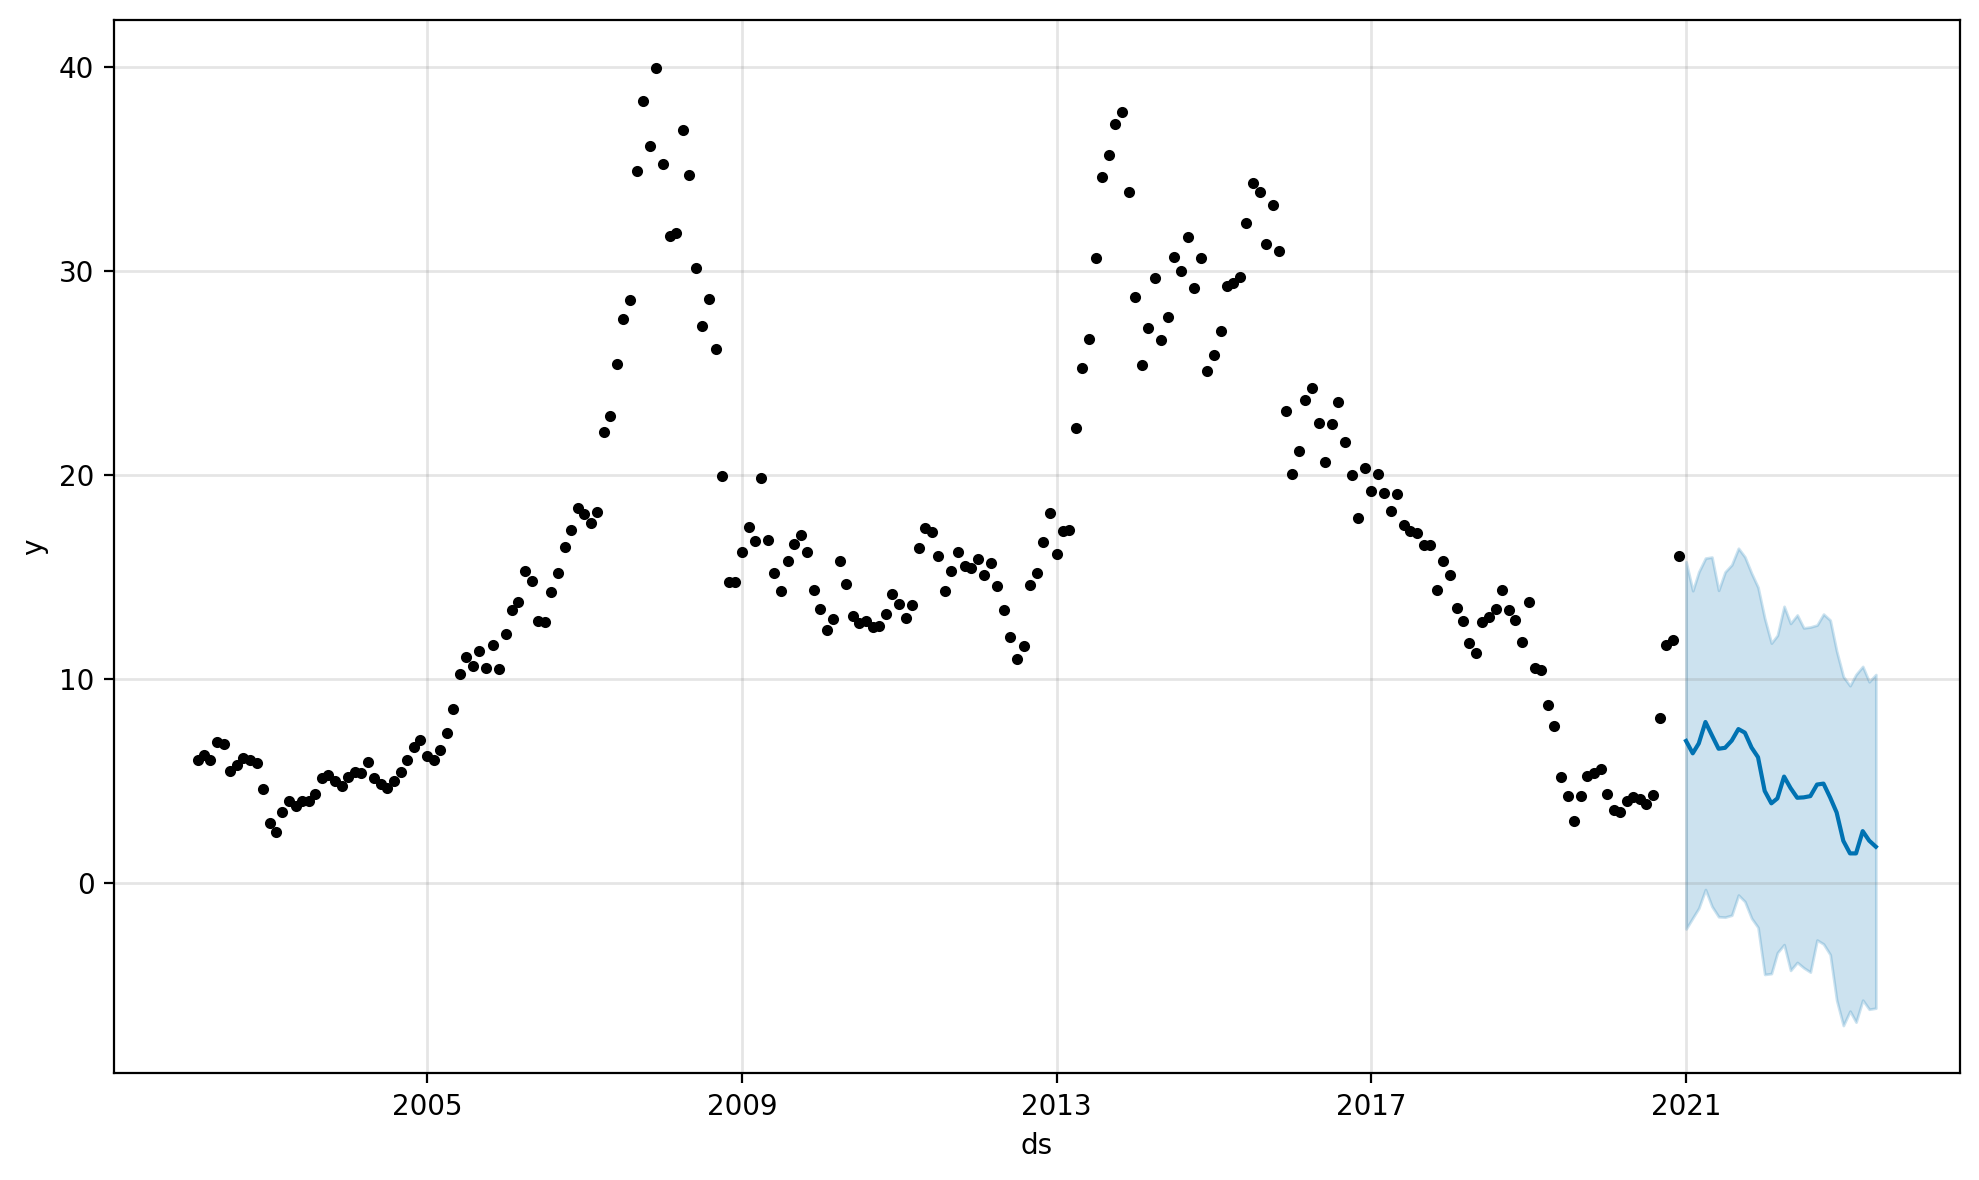

In [327]:
#Forcast the feature
feature_prediction = prophet.predict(future)

fig = prophet.plot(feature_prediction)

- Without the sharp that occured after 2020, the Prophet predict that the adjclose price will be lower than 2020, but what really happen is 2021 was the highest prices for Gamestop company.
- Market isn't stable so we can't get a good predictions all the time, like this data a lot of things happen during the past years and affected the predictions of the next years.

<br><br>

---

<br><br>

<font size='5' color='blue'> Model 3: XGBoost

## Prepare data

In [328]:
df_XGB = df_no_sharp[["adjclose_price"]].copy()

In [329]:
df_XGB["target"] = df_XGB["adjclose_price"].shift(-1)
df_XGB.head()

,adjclose_price,target
2002-02-01,6.000000,6.250000
2002-03-01,6.250000,6.000000
2002-04-01,6.000000,6.909091
2002-05-01,6.909091,6.800000
2002-06-01,6.800000,5.454545


## 3.1) check for null values

In [330]:
df_XGB.isnull().sum()

adjclose_price    0
target            1
dtype: int64

In [331]:
df_XGB.dropna(inplace=True)

## 3.2)  call walk_forward_predictions function

In [332]:
rmse, y, pred = walk_forward_predictions(df_XGB)

## 3.3) Predict XGBoost model

In [333]:
for i in range(len(pred)):
    print(f"predicted={pred[i]:4.4}, expected={y[i]}")

predicted=29.38, expected=29.7
predicted=26.62, expected=32.36363636363637
predicted=36.91, expected=34.31818181818182
predicted=35.7, expected=33.857142857142854
predicted=28.72, expected=31.333333333333332
predicted=29.18, expected=33.22727272727273
predicted=30.02, expected=30.95
predicted=30.0, expected=23.136363636363637
predicted=25.42, expected=20.05263157894737
predicted=14.74, expected=21.15
predicted=22.86, expected=23.681818181818183
predicted=20.06, expected=24.238095238095237
predicted=24.24, expected=22.523809523809526
predicted=25.23, expected=20.636363636363637
predicted=23.68, expected=22.5
predicted=20.64, expected=23.565217391304348
predicted=24.23, expected=21.61904761904762
predicted=23.68, expected=20.0
predicted=14.74, expected=17.904761904761905
predicted=17.63, expected=20.333333333333332
predicted=21.15, expected=19.2
predicted=16.8, expected=20.05263157894737
predicted=21.15, expected=19.08695652173913
predicted=20.05, expected=18.210526315789473
predicted=22

## 3.4)  Plot Prediction Vs True

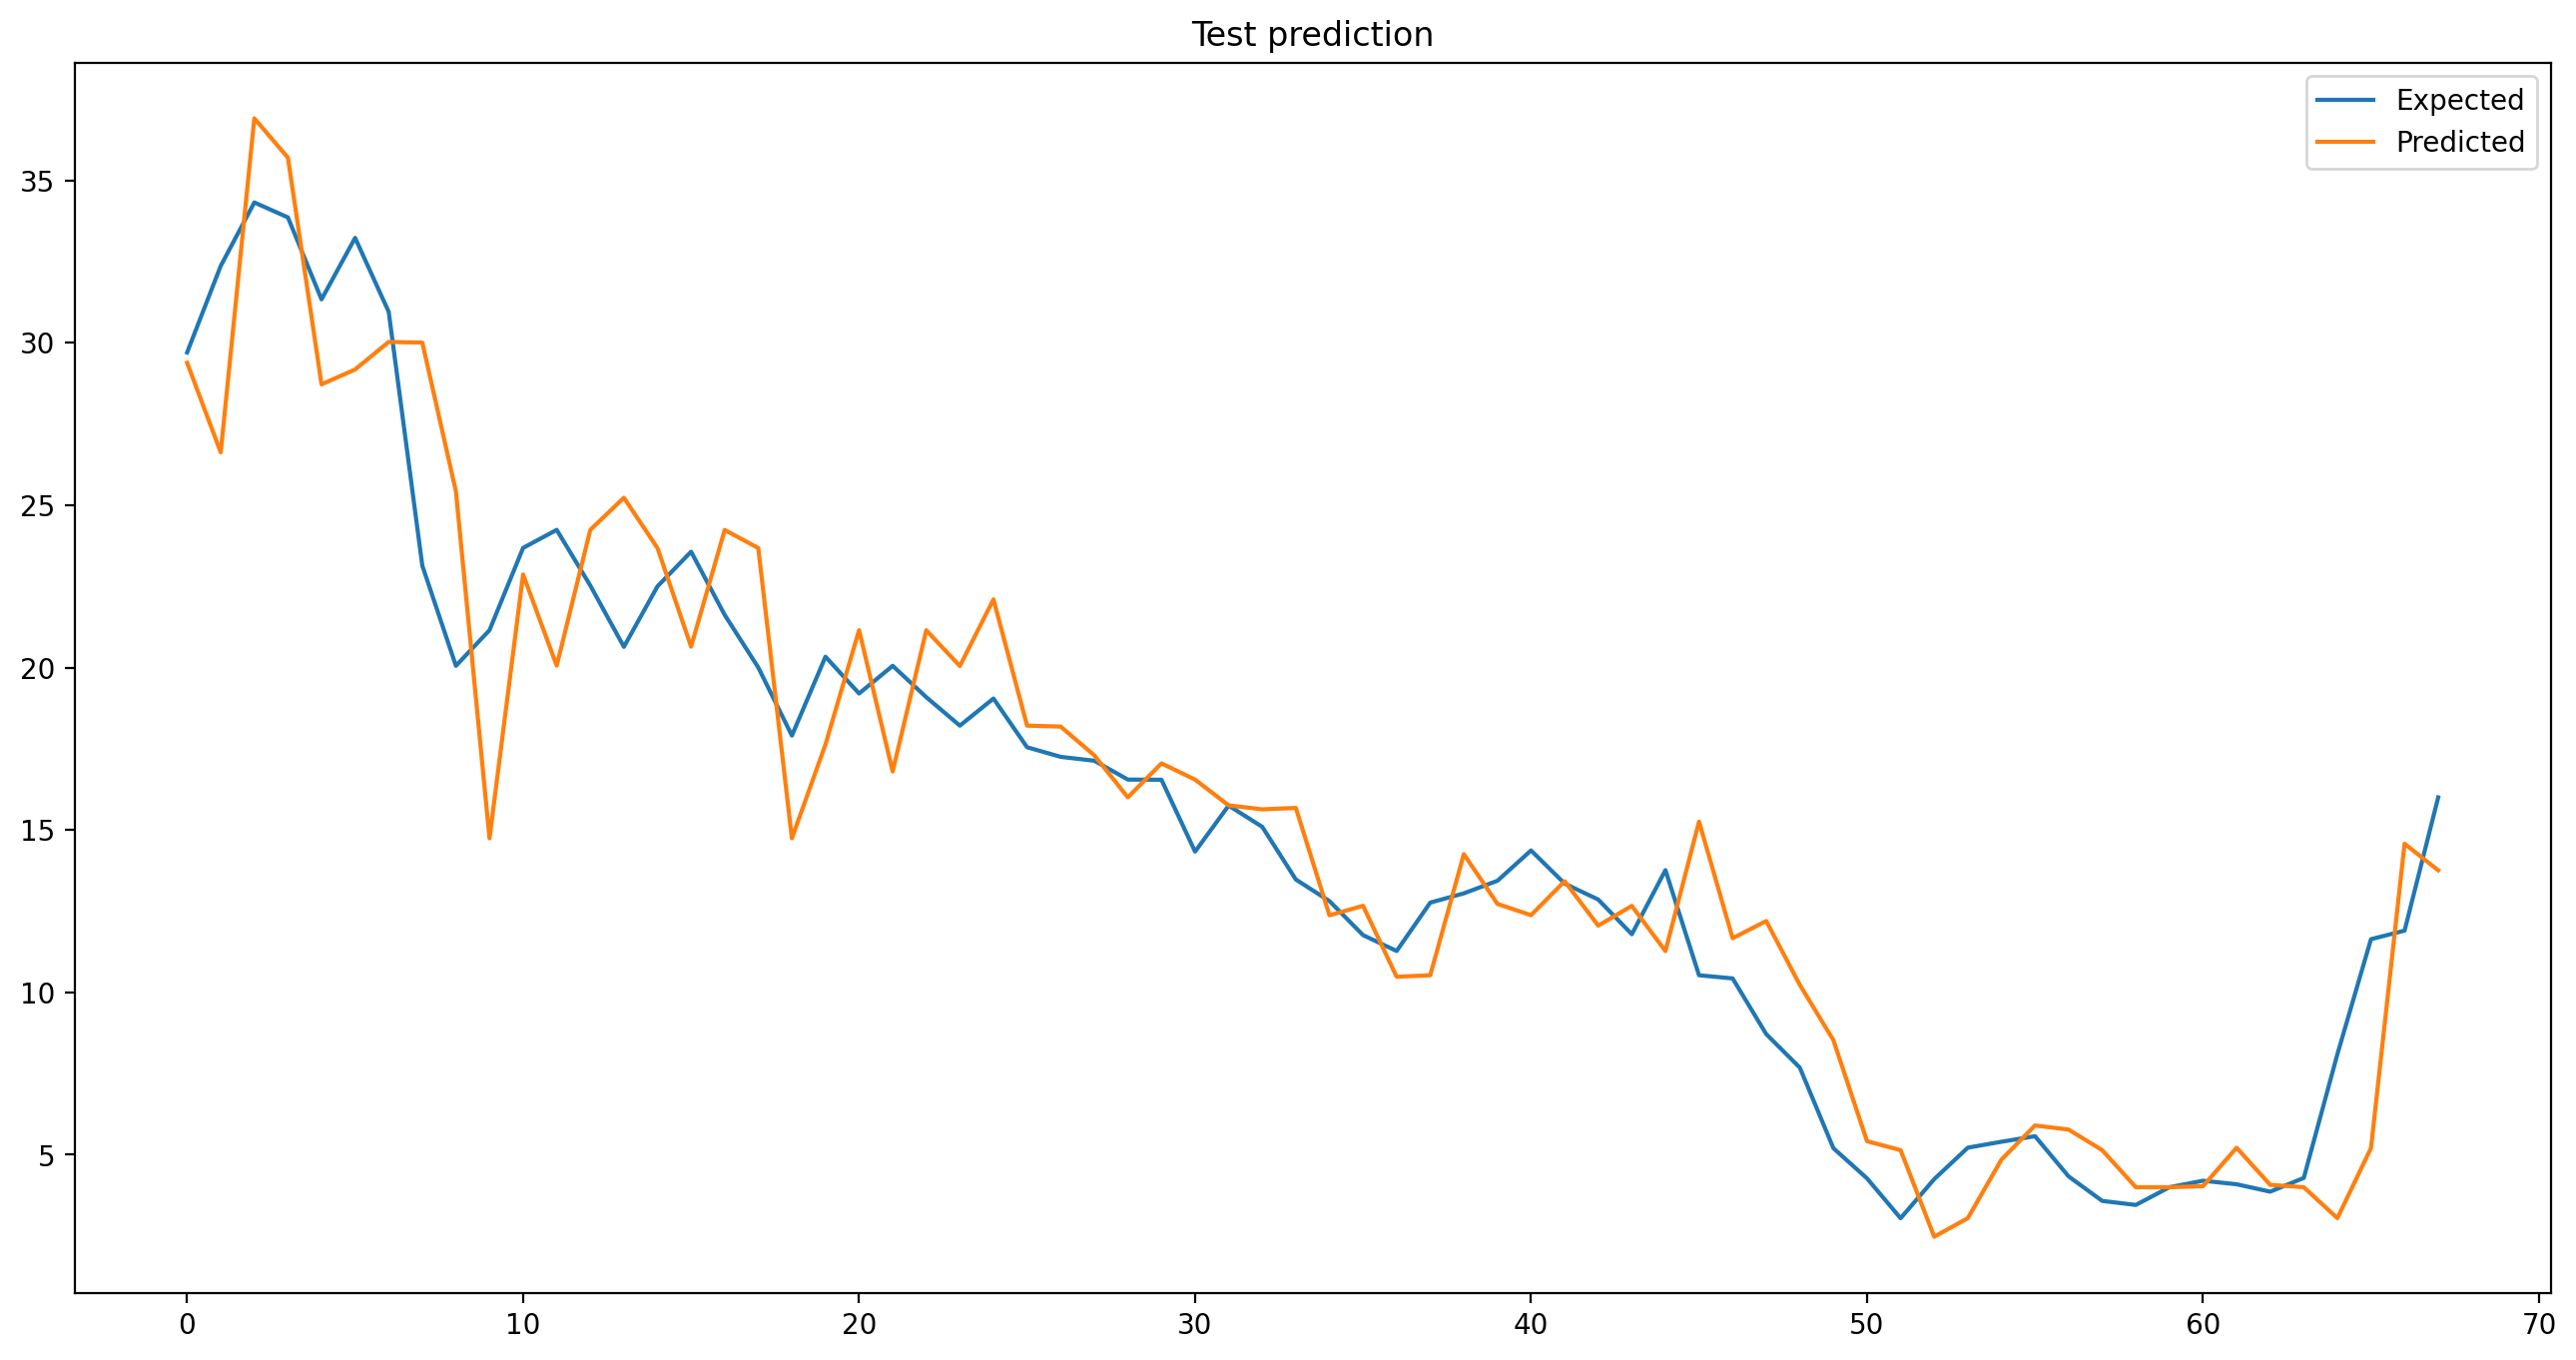

In [347]:
# plot expected vs preducted
fig = plt.figure(figsize=(16, 8))
plt.title('Test prediction')
plt.plot(y, label='Expected')

plt.plot(pred, label='Predicted')

plt.legend()
plt.show()

## 3.5) Evaluate the Model

In [335]:
print("RMSE Error:", rmse)

RMSE Error: 2.685291777457016


In [336]:
add_score('XGBoost', rmse)

,Model,Test
0,XGBoost,2.685292
1,SARIMAX,6.555137
2,F-XGBoost,6.714644
3,F-SARIMAX,11.543219
4,F-Prophet,18.175393
5,Prophet,18.362436


## 3.6) Retrain the model and forecast the future

In [337]:
#Careate a period of 2.5 year
future = pd.DataFrame(data= pd.date_range(start='1/1/2021',end='6/1/2023', freq='MS'), columns=['ds'])
len(future)

30

In [338]:
future["adjclose_price"]=0
future["target"]=0
future.set_index('ds',inplace=True)
future.index.name = None

In [339]:
forecast_XGB = pd.concat([df_XGB, future])

In [340]:
forecast_XGB["target"] = forecast_XGB["adjclose_price"].shift(-1)

#### check for null values

In [341]:
forecast_XGB.isnull().sum()

adjclose_price    0
target            1
dtype: int64

In [342]:
forecast_XGB.dropna(inplace=True)

In [343]:
forcast_xgb = pd.DataFrame(walk_forward_predictions_forecast(forecast_XGB, len(df_XGB)),
                           columns=['date', 'target']).set_index('date')
forcast_xgb.index.name = None
forcast_xgb

,target
2021-01-01,3.474859
2021-02-01,0.001364
2021-03-01,0.000460
2021-04-01,0.000489
2021-05-01,0.000327
2021-06-01,0.000188
2021-07-01,0.000019
2021-08-01,0.000315
2021-09-01,0.000308
2021-10-01,0.000036


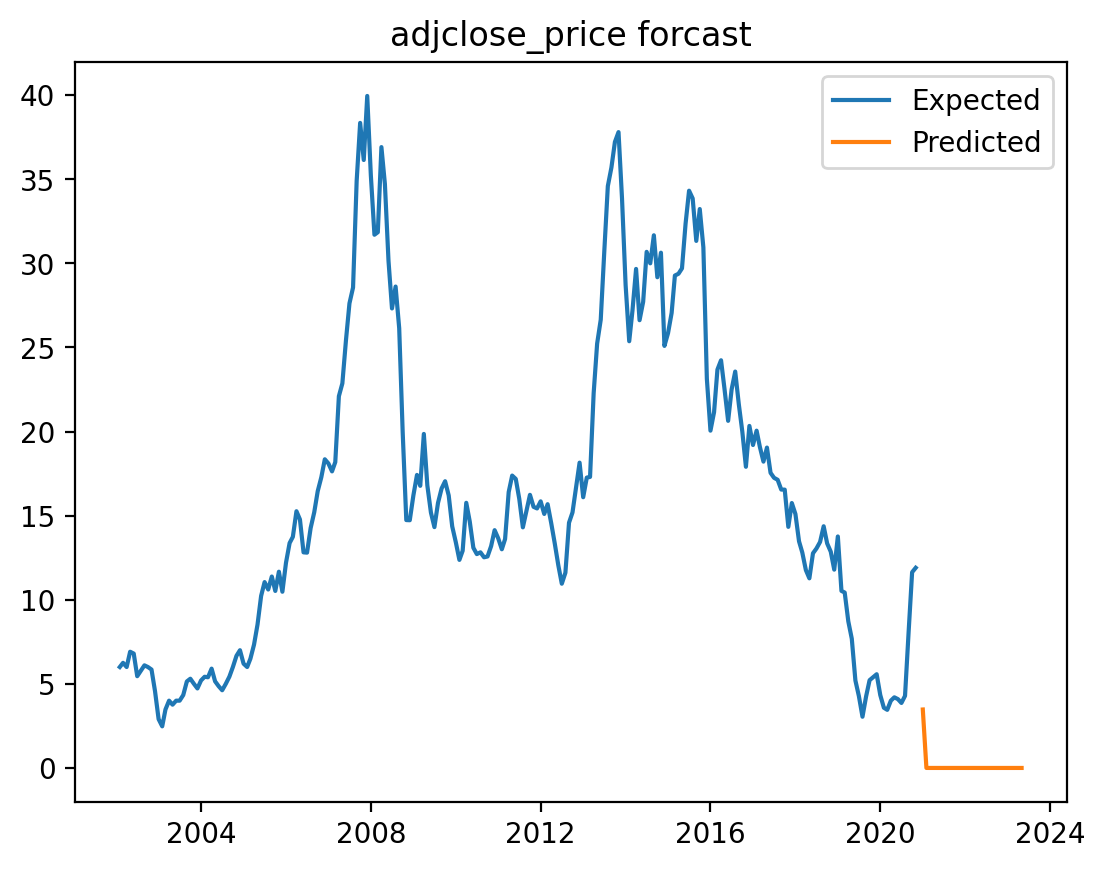

In [344]:
# Plot predictions against known values
plt.title('adjclose_price forcast')
# plot expected vs preducted
plt.plot(df_XGB['adjclose_price'], label='Expected')
plt.plot(forcast_xgb.target, label='Predicted')
plt.legend()
plt.show()

<br><br>

---

<br><br>

# Summary

Target mean 16.387499519897453


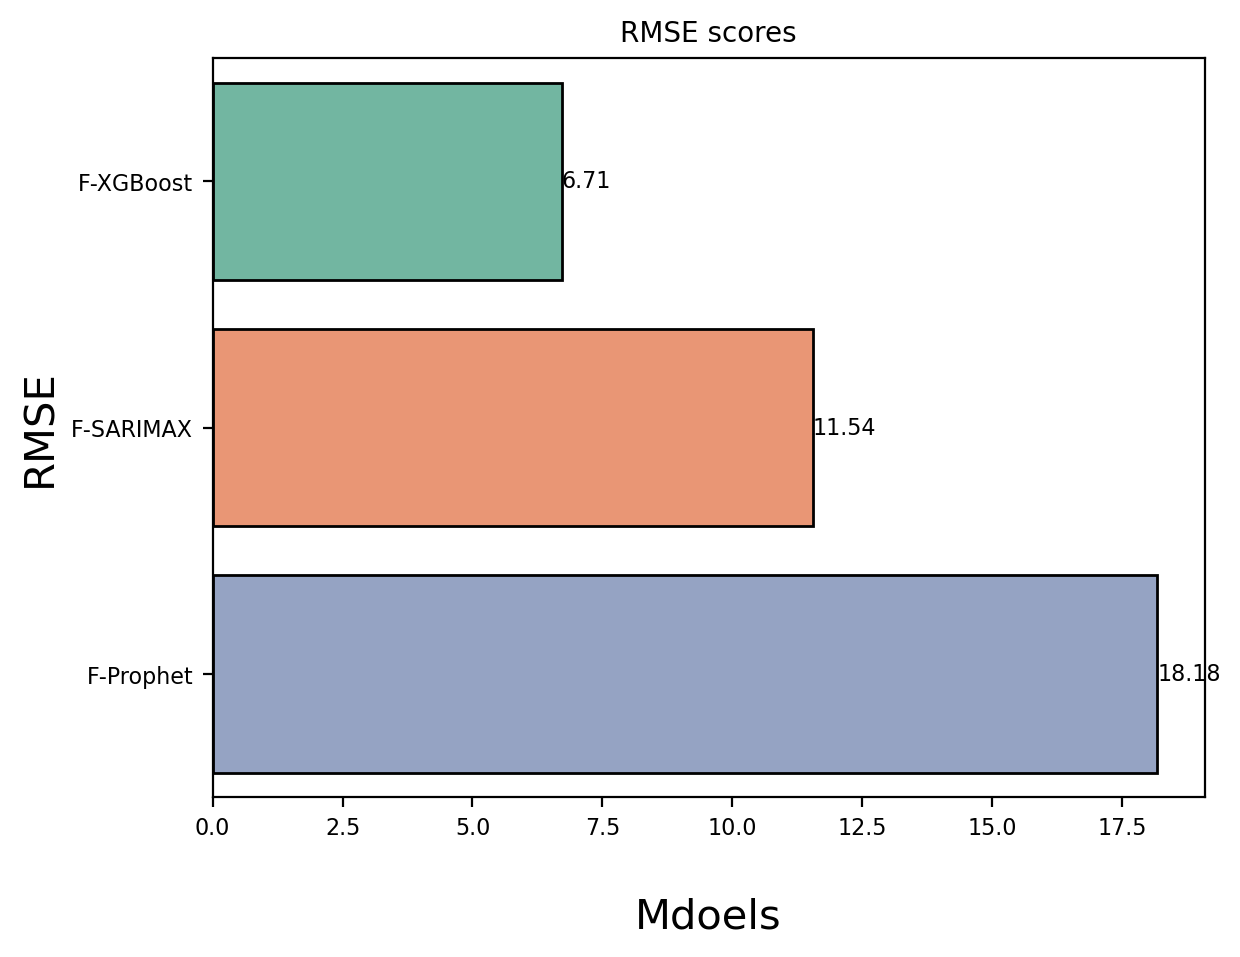

In [345]:
# .set_index()  Do not forget to use inplace
rmse_df.set_index('Model',inplace=True)
rmse_df.index.name = None

rmse_df.sort_values('Test', inplace=True)

# plt.figure(figsize=(15,8))
sns.barplot(data = rmse_df,
            x= rmse_df.Test.iloc[rmse_df.index.str.startswith('F')].values,
            y= rmse_df.Test.iloc[rmse_df.index.str.startswith('F')].index,
            orient='h',
            palette='Set2',
            edgecolor='black')


#Print each value for each bar
for index, value in enumerate(rmse_df.Test.iloc[rmse_df.index.str.startswith('F')].values):
    plt.text(value,
             index,
             round(value,2),
             fontdict={'size':8,'color':'black'},
             ha='left',
             va='center')

#Decoration
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('\nMdoels', fontsize=15)
plt.ylabel('RMSE', fontsize=15);
plt.title('RMSE scores', fontsize=10 );
print('Target mean',rdf.adjclose_price.mean());

Target mean 16.1711448922318


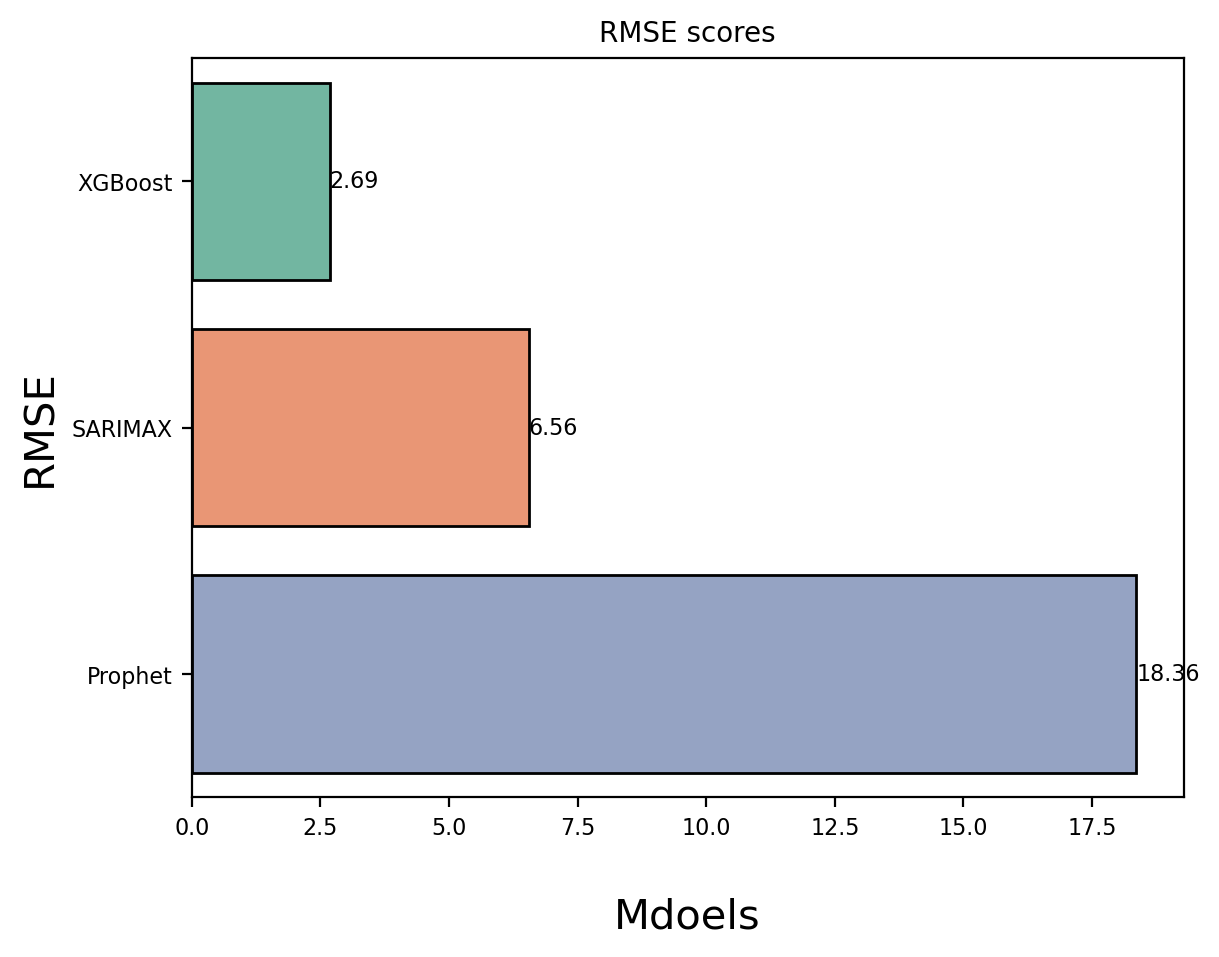

In [346]:
# plt.figure(figsize=(15,8))
sns.barplot(data = rmse_df,
            x= rmse_df.Test.iloc[~rmse_df.index.str.startswith('F')].values,
            y= rmse_df.Test.iloc[~rmse_df.index.str.startswith('F')].index,
            orient='h',
            palette='Set2',
            edgecolor='black')

#Print each value for each bar
for index, value in enumerate(rmse_df.Test.iloc[~rmse_df.index.str.startswith('F')].values):
    plt.text(value,
             index,
             round(value,2), 
             fontdict={'size':8, 'color':'black'},
             ha='left',
             va='center')

#Decoration
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('\nMdoels', fontsize=15)
plt.ylabel('RMSE', fontsize=15);
plt.title('RMSE scores', fontsize=10 );

print('Target mean',df_no_sharp.adjclose_price.mean());

- Facebook Prophet did not perform well when it comes to RMSE score, but it's the only model that could Forcast this data with, without sharp, and the noise in the values.
- SARIMAX returned a good RMSE comparing to the mean of the columns, but this is because it couldn't forecast or predict the test, so it just used the mean of the column as a prediction.
- XGBoost, performs well for predicting here, and it RMSE before and after removing the sharpness still good compared to the mean and to other models. But for forcasting it performs worst than any model.